# Change in proportion of touch neurons and tuned neurons
### Refactoring from 230108_combine_neuronal_activity_with_dataset.ipynb
### Questions
- Does proportion of touch neurons change across training?
- Does proportion of tuned neurons (among touch neurons) change across training?

# Correction
- Previously, I defined touch and tuned neurons based on p-values
- But p-values depend on the number of trials.
- Re-do the analyses again using bootstrapped p-values.
    - Also show their response amplitude.
    - First, use the p-value definition and see how they can distinguish response amplitude.
## performance calculation
- Previously, correct rate was calculated INCLUDING miss trials.
- Remove miss trials to calculate the performance. (def calculate_correct_rate)

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import os, glob, h5py
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import notebook
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import socket
%matplotlib inline

h5_dir_1 = Path('F:/')
h5_dir_2 = Path('D:/')
mice =          [25,    27,   30,   36,     37,     38,     39,     41,     52,     53,     54,     56]
expert_mice = [25, 27, 30, 36, 39, 52]
ref_sessions = [4,3,3,1,1,3]
exp_sessions = [19,10,21,17,23,21]
# refSessions =   [4,     3,    3,    1,      7,      2,      1,      3,      3,      3,      3,      3]
# expSessions =   [19,    10,   21,   17,     0,      0,      23,     0,      21,     0,      0,      0]
# zoom =          [2,     2,    2,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7]
image_rate_list = [30.8359, 30.8359, 30.8359, 30.8359, 
                    24.2892, 24.2892, 24.2892, 24.2892,
                    30.8359, 30.8359, 30.8359, 30.8359] # from .mat file (sbx)
image_size_list = [[512,796], [512,796], [512,796], [512,796], 
                    [650,796], [650,796], [650,796], [650,796], 
                    [512,796], [512,796], [512,796], [512,796]] # from .mat file (sbx)
planes = range(1,9)

if socket.gethostname() == 'OSXLTR6HX40':
    save_dir_base = Path('/Users/jinho.kim/Dropbox/Works/Projects/2020 Neural stretching in S1/Results')
    data_dir_base = Path('/Users/jinho.kim/Dropbox/Works/Projects/2020 Neural stretching in S1/Data')
elif socket.gethostname() == 'HNB228-LABPC6':  # 64 core
    save_dir_base = Path(r'C:\Users\shires\Dropbox\Works\Projects\2020 Neural stretching in S1\Results')
    data_dir_base = Path(r'C:\Users\shires\Dropbox\Works\Projects\2020 Neural stretching in S1\Data')
else:
    save_dir_base = Path(r'C:\Users\jinho\Dropbox\Works\Projects\2020 Neural stretching in S1\Results')
    data_dir_base = Path(r'C:\Users\jinho\Dropbox\Works\Projects\2020 Neural stretching in S1\Data')
h5_dir = data_dir_base / 'h5'

In [3]:
# Function calculating correct rate
def calculate_correct_rate(wb_df):
    temp_df = wb_df.drop_duplicates('trialNum')[['trialNum','correct','wrong','miss']]
    num_trials = len(temp_df)
    num_correct = temp_df.correct.sum()
    num_wrong = temp_df.wrong.sum()
    num_miss = temp_df.miss.sum()
    num_answer = num_correct + num_wrong
    assert num_correct + num_wrong + num_miss == num_trials
    answer_rate = 1 - num_miss / num_trials
    correct_rate = num_correct / num_answer
    return correct_rate, num_answer, answer_rate

In [ ]:
# # Making crude tourh response dataframes
# # Save f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl' files
# # Run for 025, 027, 030 at 1/10/2023. Do not overwrite the files, just load them.

# trial_start_buffer_frame = 3 # to prevent abrupt increase of signal by laser on after ITI and possible contamination by trial start cue

# for emi in range(3):
#     for plane in range(1,9):

#         mouse = expert_mice[emi]
#         if emi < 3:
#             h5_dir = h5_dir_1
#         else:
#             h5_dir = h5_dir_2

#         plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
#         sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
#         session_nums = sts_reg['selected_session_num']

#         tr_sessions = [] # touch response sessions
#         tr_num_roi = []
#         tr_correct_rate = []
#         tr_num_answer = []
#         tr_num_touch_trials = []
#         tr_pre_pole_len = []
#         tr_angle = []
#         tr_correct = []
#         tr_num_pre_answer_touch = []
#         tr_num_post_answer_touch = []

#         tr_p_pre_answer = []
#         tr_p_post_answer = []
#         tr_p_post_pre = []
#         tr_effect_pre_answer = []
#         tr_effect_post_answer = []
#         tr_effect_post_pre = []

#         tr_pre_pole_activity = []
#         tr_pre_answer_response = []
#         tr_post_answer_response = []
#         tr_post_pole_activity = []

#         # Load iscell, which is same for all the sessions in a plane
#         session_num = session_nums[0]
#         session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
#         iscell = np.load(session_roi_dir / 'iscell.npy', allow_pickle=True)[:,0] # Same for all sessions in a plane
#         iscell_ind = np.where(iscell)[0]
#         num_cell = len(iscell_ind)
#         for session_num in session_nums:
#             session_plane_info = f'JK{mouse:03d} S{session_num:02d} plane{plane}'
#             print(f'Processing {session_plane_info}')
            
#             # Load events and z-score them
#             session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
#             events = np.load(session_roi_dir / 'spks.npy', allow_pickle=True).transpose() # To make each cell in each column, and column-direction matches with whisker-behavior dataFrame.
#             events_zscore = (events - np.mean(events, axis=0)) / np.std(events, axis=0)
#             assert events.shape[1] == len(iscell)
#             events_zscore = events_zscore[:,iscell_ind]

#             # Load whisker-behavior dataFrame
#             wb_pkl_fn = f'JK{mouse:03d}_S{session_num:02d}_plane{plane}_frame_whisker_behavior.pkl'
#             if os.path.isfile(plane_dir / wb_pkl_fn):
#                 wb_df = pd.read_pickle(plane_dir / wb_pkl_fn)
#                 if wb_df.task_target.values[-1] == 'Angle': # 2-angle training sessions only
#                     if np.nansum(wb_df.touch_count.values) > 0: # removing whisker-less sessions
#                         correct_rate, num_answer, answer_rate = calculate_correct_rate(wb_df)
                        
#                         trial_nums = wb_df.trialNum.unique()
#                         pre_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
#                         pre_pole_activity[:] = np.nan
#                         pre_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
#                         pre_answer_response[:] = np.nan
#                         post_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
#                         post_answer_response[:] = np.nan
#                         post_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
#                         post_pole_activity[:] = np.nan
#                         pre_pole_length = np.empty(len(trial_nums),)
#                         pre_pole_length[:] = np.nan
#                         angle = np.empty(len(trial_nums),)
#                         angle[:] = np.nan
#                         correct = np.empty(len(trial_nums),)
#                         correct[:] = np.nan
#                         num_pre_answer_touch = np.empty(len(trial_nums),)
#                         num_pre_answer_touch[:] = np.nan
#                         num_post_answer_touch = np.empty(len(trial_nums),)
#                         num_post_answer_touch[:] = np.nan
#                         num_touch_trial = 0
#                         for ti, trial_num in enumerate(trial_nums):
#                             trial_wb_df = wb_df[wb_df.trialNum == trial_num]
#                             if (not trial_wb_df.iloc[0].miss) and (np.nansum(trial_wb_df.touch_count.values) > 0): # only when there was an answer and at least one touch
#                                 num_touch_trial += 1

#                                 angle[ti] = trial_wb_df.iloc[0].pole_angle
#                                 correct[ti] = trial_wb_df.iloc[0].correct
                                
#                                 trial_events_zscore = events_zscore[np.where(wb_df.trialNum == trial_num)[0],:]
#                                 if len(np.where(trial_wb_df.pole_moving_frame.values)[0]) > 0:
#                                     first_pole_moving_ind = min(np.where(trial_wb_df.pole_up_frame.values)[0][0], np.where(trial_wb_df.pole_moving_frame.values)[0][0])
#                                 else:
#                                     first_pole_moving_ind = np.where(trial_wb_df.pole_up_frame.values)[0][0]
#                                 pre_pole_inds = range(trial_start_buffer_frame,first_pole_moving_ind)
#                                 pre_pole_length[ti] = len(pre_pole_inds)
#                                 pre_answer_pole_inds = range(np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][0], np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][-1] +2)
#                                 pre_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[pre_answer_pole_inds])

#                                 post_answer_pole_inds = np.where(trial_wb_df.post_answer_pole_up_frame.values)[0] # last frame should be included
#                                 post_pole_inds = []
                                
#                                 if len(post_answer_pole_inds) > 0:
#                                     assert post_answer_pole_inds[0] - pre_answer_pole_inds[-1] == 1
#                                     post_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[post_answer_pole_inds])
#                                     if len(trial_wb_df) > post_answer_pole_inds[-1]:
#                                         post_pole_inds = range(post_answer_pole_inds[-1]+1, len(trial_wb_df))
#                                 else:
#                                     post_answer_num_touch = 0
                                
#                                 num_pre_answer_touch[ti] = pre_answer_num_touch
#                                 num_post_answer_touch[ti] = post_answer_num_touch

#                                 assert len(np.intersect1d(pre_pole_inds, pre_answer_pole_inds))==0
#                                 assert len(np.intersect1d(pre_answer_pole_inds, post_answer_pole_inds))==0
                                
#                                 pre_pole_activity[ti,:] = np.mean(trial_events_zscore[pre_pole_inds, :], axis=0)
#                                 if pre_answer_num_touch > 0:
#                                     pre_answer_response[ti,:] = np.mean(trial_events_zscore[pre_answer_pole_inds,:], axis=0) / pre_answer_num_touch
#                                 if post_answer_num_touch > 0:
#                                     post_answer_response[ti,:] = np.mean(trial_events_zscore[post_answer_pole_inds,:], axis=0) / post_answer_num_touch
#                                 if len(post_pole_inds) > 0:
#                                     post_pole_activity[ti,:] = np.mean(trial_events_zscore[post_pole_inds, :], axis=0)
                        
#                         pvalue_pre_answer_response = stats.ttest_1samp(pre_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
#                         pvalue_post_answer_response = stats.ttest_1samp(post_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
#                         pvalue_post_pre_answer = stats.ttest_1samp(post_answer_response - pre_answer_response, 0, nan_policy='omit')[1].data
#                         effect_pre_answer_response = np.nanmean(pre_answer_response - pre_pole_activity, axis=0)
#                         effect_post_answer_response = np.nanmean(post_answer_response - pre_pole_activity, axis=0)
#                         effect_post_pre_answer = np.nanmean(post_answer_response - pre_answer_response, axis=0)

#                         # Collect the results
#                         tr_sessions.append(session_num)
#                         tr_num_roi.append(num_cell)
#                         tr_correct_rate.append(correct_rate)
#                         tr_num_answer.append(num_answer)
#                         tr_num_touch_trials.append(num_touch_trial)
#                         tr_pre_pole_len.append(pre_pole_length)
#                         tr_angle.append(angle)
#                         tr_correct.append(correct)
#                         tr_num_pre_answer_touch.append(num_pre_answer_touch)
#                         tr_num_post_answer_touch.append(num_post_answer_touch)

#                         tr_p_pre_answer.append(pvalue_pre_answer_response)
#                         tr_p_post_answer.append(pvalue_post_answer_response)
#                         tr_p_post_pre.append(pvalue_post_pre_answer)
#                         tr_effect_pre_answer.append(effect_pre_answer_response)
#                         tr_effect_post_answer.append(effect_post_answer_response)
#                         tr_effect_post_pre.append(effect_post_pre_answer)

#                         tr_pre_pole_activity.append(pre_pole_activity)
#                         tr_pre_answer_response.append(pre_answer_response)
#                         tr_post_answer_response.append(post_answer_response)
#                         tr_post_pole_activity.append(post_pole_activity)

#         # Save results in pkl file as DataFrame
#         tr_crude = pd.DataFrame({'session': tr_sessions,
#                                 'num_roi': tr_num_roi,
#                                 'correct_rate': tr_correct_rate,
#                                 'num_answer': tr_num_answer,
#                                 'num_touch_trials': tr_num_touch_trials,
#                                 'pre_pole_len': tr_pre_pole_len,
#                                 'angle': tr_angle,
#                                 'correct': tr_correct,
#                                 'num_touch_pre_answer': tr_num_pre_answer_touch,
#                                 'num_touch_post_answer': tr_num_post_answer_touch,
#                                 'p_pre_answer': tr_p_pre_answer,
#                                 'p_post_answer': tr_p_post_answer,
#                                 'effect_size_pre_answer': tr_effect_pre_answer,
#                                 'effect_size_post_answer': tr_effect_post_answer,
#                                 'effect_size_post_pre': tr_effect_post_pre,
#                                 'pre_pole_activity': tr_pre_pole_activity,
#                                 'pre_answer_response': tr_pre_answer_response,
#                                 'post_answer_response': tr_post_answer_response,
#                                 'post_pole_activity': tr_post_pole_activity,
#                                 })
#         save_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
#         tr_crude.to_pickle(save_dir_base / save_fn)
# # Took 5 min for 3 mice

## Make figures of touch response (p-value and response amplitude)

In [3]:
# def calculate_p_and_response_touch(tr_crude, pre_post, sortby):
#     num_roi = tr_crude.num_roi.values[0]
#     session_nums = tr_crude.session.values
#     pval = []
#     if pre_post == 'pre':
#         pvalues_list = tr_crude.p_pre_answer.values
#     elif pre_post == 'post':
#         pvalues_list = tr_crude.p_post_answer.values
#     else:
#         raise ValueError('pre_post is not valid')

#     for ppa in pvalues_list:
#         if len(pval) == 0:
#             pval = -np.log10(ppa)
#         else:
#             pval = np.vstack((pval, -np.log10(ppa)))
#     pval = pval.transpose()

#     if sortby == 'first':
#         sort_i = np.argsort(-pval[:,0])
#     elif sortby == 'mean':
#         sort_i = np.argsort(-np.nanmean(pval, axis=1))
#     else:
#         raise ValueError('sorting_list[sorting_i] is not valid')
#     sorted_p = pval[sort_i,:]

#     response = []
#     for epa in tr_crude.effect_size_pre_answer.values:
#         if len(response) == 0:
#             response = epa
#         else:
#             response = np.vstack((response, epa))
#     response = response.transpose()
#     sorted_response = response[sort_i, :]

#     return sorted_p, sorted_response, sort_i, session_nums

# def fig_p_and_response_touch(mouse, plane, sorted_p, sorted_response, session_nums, pre_post, sortby):
#     fig, ax = plt.subplots(1,2,figsize=(sorted_response.shape[1],sorted_response.shape[0]/20))
#     p_matrix = ax[0].imshow(sorted_p, vmin=1, vmax=4, aspect='auto')
#     ax[0].set_xticks(range(len(session_nums)))
#     ax[0].set_xticklabels(session_nums, fontsize=15, rotation=45)
#     ax[0].set_xlabel('Session#', fontsize=20)
#     ax[0].set_ylabel('Cell ID (sorted)', fontsize=20)
#     cb = fig.colorbar(p_matrix, ax=ax[0]).set_label(label='-log(p-value)', size=20)
#     # cb.ax.tick_params(labelsize=15)
#     e_matrix = ax[1].imshow(sorted_response, vmin=0, vmax=0.25, aspect='auto')
#     ax[1].set_xticks(range(len(session_nums)))
#     ax[1].set_xticklabels(session_nums, fontsize=15, rotation=45)
#     ax[1].set_xlabel('Session#', fontsize=20)
#     cb = fig.colorbar(e_matrix, ax=ax[1]).set_label(label='Response amplitude (z-score)', size=20)
#     fig.suptitle(f'JK{mouse:03d} plane{plane} - {pre_post}-answer touch response\n(sorted by {sortby})', fontsize=20)
#     fig.tight_layout()
#     return fig

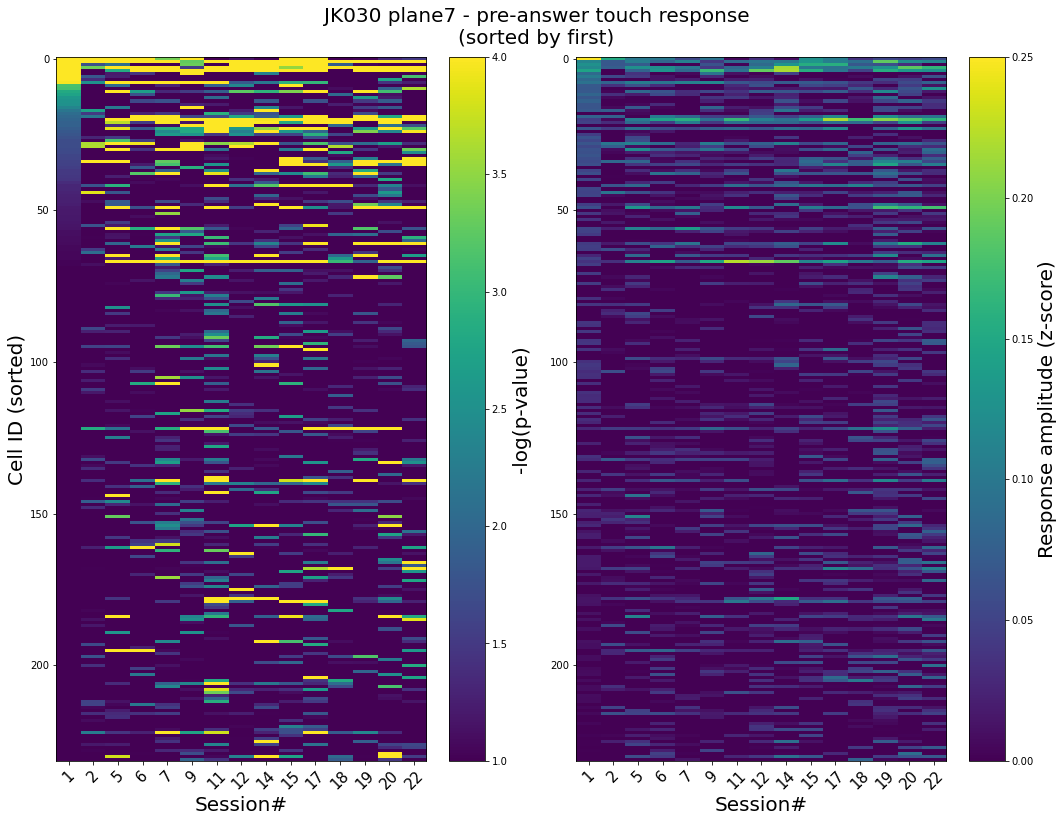

In [6]:
# # Single plane example
# save_fig = False
# sortby_list = ['first', 'mean']
# pre_post_list = ['pre', 'post']

# sortby = sortby_list[0]
# pre_post = pre_post_list[0]
# mi = 2
# mouse = expert_mice[mi]
# plane = 7

# load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
# tr_crude = pd.read_pickle(save_dir_base / load_fn)

# sorted_p, sorted_response, sort_i, session_nums = calculate_p_and_response_touch(tr_crude, pre_post, sortby)
# fig = fig_p_and_response_touch(mouse, plane, sorted_p, sorted_response, session_nums, pre_post, sortby)

# if save_fig:
#     save_dir = save_dir_base / 'touch_response' / f'{pre_post}_answer'
#     if not save_dir.exists():
#         save_dir.mkdir(parents=True)
#     save_fn = f'JK{mouse:03d}_plane{plane}_{pre_post}_answer_touch_response(sort_by_{sortby}).png'
#     fig.savefig(save_dir / save_fn, dpi=300)

In [4]:
# # pre-answer touch response effect size
# # Sorted by either p-value of first session or by the mean p-value of all sessions, per plane
# sortby_list = ['first', 'mean']
# pre_post_list = ['pre', 'post']

# for mi in range(3):
#     mouse = expert_mice[mi]
#     for plane in range(1,9):
#         for pre_post in pre_post_list:
#             for sortby in sortby_list:
#                 load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
#                 tr_crude = pd.read_pickle(save_dir_base / load_fn)

#                 sorted_p, sorted_response, sort_i, session_nums = calculate_p_and_response_touch(tr_crude, pre_post, sortby)
#                 fig = fig_p_and_response_touch(mouse, plane, sorted_p, sorted_response, session_nums, pre_post, sortby)

#                 save_dir = save_dir_base / 'touch_response' / f'{pre_post}_answer'
#                 if not save_dir.exists():
#                     save_dir.mkdir(parents=True)
#                 save_fn = f'JK{mouse:03d}_plane{plane}_{pre_post}_answer_touch_response(sort_by_{sortby}).png'
#                 fig.savefig(save_dir / save_fn, dpi=300, bbox_inches='tight', transparent=False)
#                 plt.close(fig)

## Result
- Less touch neurons from post-answer response.
- Increased response amplitude during training, only in the upper planes.<br>

Quantify them

## Proportion of touch neurons across training
- Pre vs post answer
- Plot with the performance

In [4]:
def plot_prop_touch_with_perf_plane(mouse, plane, touch_p_threshold=0.01):
    load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
    tr_crude = pd.read_pickle(save_dir_base / load_fn)
    num_touch_pre_answer = tr_crude.p_pre_answer.apply(lambda x: len(np.where(x<touch_p_threshold)[0]))
    prop_touch_pre_answer = num_touch_pre_answer / tr_crude.num_roi.values
    num_touch_post_answer = tr_crude.p_post_answer.apply(lambda x: len(np.where(x<touch_p_threshold)[0]))
    prop_touch_post_answer = num_touch_post_answer / tr_crude.num_roi.values
    task_performance = tr_crude.correct_rate.values
    session_nums = tr_crude.session.values
    fig, ax = plt.subplots(1,1,figsize=(5,3))
    ax.plot(session_nums, prop_touch_pre_answer, 'o-', label='pre-answer')
    ax.plot(session_nums, prop_touch_post_answer, 'o-', label='post-answer')
    ax2 = ax.twinx()
    ax2.plot(session_nums, task_performance, 'ko-', label='task performance')
    ax.legend(loc='upper left')
    ax.set_xlabel('Session #')
    ax.set_ylabel('Proportion of ROIs with touch response')
    ax2.set_ylabel('Task performance')
    ax.set_ylim([0, 0.8])
    ax2.set_ylim([0.2, 1])
    ax.set_title(f'JK{mouse:03d} plane{plane} - touch response proportion')
    # change the color of ax y axis, y label, and y ticks to the color matched to pre-answer plot    
    ax.tick_params(axis='y', colors='C0')
    ax.yaxis.label.set_color('C0')
    ax2.spines['left'].set_color('C0')
    return fig

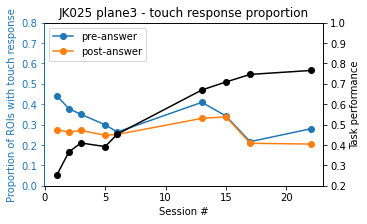

In [8]:
# Per plane plot
# One example plane
touch_p_threshold = 0.01
emi = 0
mouse = expert_mice[emi]
plane = 3
fig = plot_prop_touch_with_perf_plane(mouse, plane, touch_p_threshold)


In [6]:
# Plot for all mice and all planes
touch_p_threshold = 0.01
for emi in range(3):
    mouse = expert_mice[emi]
    for plane in range(1,9):
        fig = plot_prop_touch_with_perf_plane(mouse, plane, touch_p_threshold)
        save_dir = save_dir_base / 'prop_touch_response' / 'per_plane'
        if not save_dir.exists():
            save_dir.mkdir(parents=True)
        save_fn = f'JK{mouse:03d}_plane{plane}_prop_touch_response.png'
        fig.savefig(save_dir / save_fn, dpi=300, bbox_inches='tight', transparent=False)
        plt.close(fig)

In [27]:
# Plot per volume
def plot_prop_touch_with_perf_volume(mouse, touch_p_threshold=0.01):
    fig, ax = plt.subplots(3,2,figsize=(12,12))
    planes = range(1,9)
    num_touch_pre_plane = []
    num_touch_post_plane = []
    num_roi_plane = []
    session_nums_plane = []
    for plane in planes:
        ax_col = 0 if plane < 5 else 1
        load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
        tr_crude = pd.read_pickle(save_dir_base / load_fn)
        num_touch_pre_answer = tr_crude.p_pre_answer.apply(lambda x: len(np.where(x<touch_p_threshold)[0]))
        num_touch_pre_plane.append(num_touch_pre_answer)
        prop_touch_pre_answer = num_touch_pre_answer / tr_crude.num_roi.values
        
        num_touch_post_answer = tr_crude.p_post_answer.apply(lambda x: len(np.where(x<touch_p_threshold)[0]))
        num_touch_post_plane.append(num_touch_post_answer)
        prop_touch_post_answer = num_touch_post_answer / tr_crude.num_roi.values
        session_nums = tr_crude.session.values
        session_nums_plane.append(session_nums)

        num_roi_plane.append(tr_crude.num_roi.values)

        ax[0,ax_col].plot(session_nums, prop_touch_pre_answer, 'o-', label=f'plane {plane}')
        ax[1,ax_col].plot(session_nums, prop_touch_post_answer, 'o-', label=f'plane {plane}')

        if plane == 1:
            ax[2,0].plot(session_nums, tr_crude.correct_rate.values, 'o-', linewidth=5)
        elif plane == 5:
            ax[2,1].plot(session_nums, tr_crude.correct_rate.values, 'o-', linewidth=5)

    ax[0,0].set_ylabel('Prop touch')
    ax[1,0].set_ylabel('Prop touch')
    ax[2,0].set_ylabel('Performance')
    ax[0,0].set_title('Pre answer')
    ax[0,1].set_title('Pre answer')
    ax[1,0].set_title('Post answer')
    ax[1,1].set_title('Post answer')
    ax[0,0].legend()
    ax[0,1].legend()

    # Add volume mean data
    # Upper volume
    num_touch_pre = np.vstack([num_touch_pre_plane[:4]])
    num_touch_post = np.vstack([num_touch_post_plane[:4]])
    num_roi = np.vstack([num_roi_plane[:4]])
    mean_prop_touch_pre = np.sum(num_touch_pre,axis=0) / np.sum(num_roi,axis=0)
    mean_prop_touch_post = np.sum(num_touch_post,axis=0) / np.sum(num_roi,axis=0)
    ax[0,0].plot(session_nums_plane[0], mean_prop_touch_pre, 'ko-', linewidth=5)
    ax[1,0].plot(session_nums_plane[0], mean_prop_touch_post, 'ko-', linewidth=5)

    # Lower volume
    num_touch_pre = np.vstack([num_touch_pre_plane[5:]])
    num_touch_post = np.vstack([num_touch_post_plane[5:]])
    num_roi = np.vstack([num_roi_plane[5:]])
    mean_prop_touch_pre = np.sum(num_touch_pre,axis=0) / np.sum(num_roi,axis=0)
    mean_prop_touch_post = np.sum(num_touch_post,axis=0) / np.sum(num_roi,axis=0)
    ax[0,1].plot(session_nums_plane[4], mean_prop_touch_pre, 'ko-', linewidth=5)
    ax[1,1].plot(session_nums_plane[4], mean_prop_touch_post, 'ko-', linewidth=5)

    fig.suptitle(f'JK{mouse:03d} - touch response proportion')
    fig.tight_layout()
    return fig

# Plot for all mice
touch_p_threshold = 0.01
for emi in range(3):
    mouse = expert_mice[emi]
    fig = plot_prop_touch_with_perf_volume(mouse, touch_p_threshold)
    save_dir = save_dir_base / 'touch_prop_with_performance' / 'per_volume'
    if not save_dir.exists():
        save_dir.mkdir(parents=True)
    save_fn = f'JK{mouse:03d}_prop_touch_response.png'
    fig.savefig(save_dir / save_fn, dpi=300, bbox_inches='tight', transparent=False, facecolor='w')
    plt.close(fig)

# Tuning
- Among touch responsive neurons.
    - Defined by p < 0.01, as it roughly corresponds to 20-30% of neurons (similar to previous analyses, Peron 2015; Kim 2020)
- Tuning defined by t-test

In [5]:
# Find angle-tuned neurons
def calculate_tuned_response(tr_crude, window='pre_answer', p_threshold_touch_response=0.01):    
    num_rois = tr_crude.iloc[0].num_roi
    session_nums = tr_crude.session.values
    num_sessions = len(session_nums)
    p_tuned = np.empty((num_sessions,num_rois))
    p_tuned[:] = np.nan
    effect_tuned = np.empty((num_sessions,num_rois))
    effect_tuned[:] = np.nan

    for si in range(num_sessions):
        if window == 'pre_answer':
            cell_ind_touch_response = np.where(tr_crude.iloc[si].p_pre_answer < p_threshold_touch_response)[0]
        elif window == 'post_answer':
            cell_ind_touch_response = np.where(tr_crude.iloc[si].p_post_answer < p_threshold_touch_response)[0]
        else:
            raise ValueError('window must be either pre_answer or post_answer')
        trial_ind_45 = np.where(tr_crude.iloc[si].angle == 45)[0]
        trial_ind_135 = np.where(tr_crude.iloc[si].angle == 135)[0]
        pre_pole_activity = tr_crude.iloc[si].pre_pole_activity
        pre_answer_response = tr_crude.iloc[si].pre_answer_response
        touch_response = pre_answer_response - pre_pole_activity
        for ci in range(len(cell_ind_touch_response)):
            cell_ind = cell_ind_touch_response[ci]
            touch_response_45 = touch_response[trial_ind_45,cell_ind]
            finite_45_inds = np.where(np.isfinite(touch_response_45))[0]
            touch_response_135 = touch_response[trial_ind_135,cell_ind]
            finite_135_inds = np.where(np.isfinite(touch_response_135))[0]
            if (len(finite_45_inds) > 10) and (len(finite_135_inds) > 10):
                touch_response_45 = touch_response_45[finite_45_inds]
                touch_response_135 = touch_response_135[finite_135_inds]
                t = stats.ttest_ind(touch_response_45, touch_response_135)
                p = t.pvalue
                es = np.mean(touch_response_45) - np.mean(touch_response_135)

                p_tuned[si,ci] = p
                effect_tuned[si,ci] = es
    return p_tuned, effect_tuned



In [ ]:
# Test in a single plane
mouse = 25
plane = 1
load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
tr_crude = pd.read_pickle(save_dir_base / load_fn)
p_tuned, effect_tuned = calculate_tuned_response(tr_crude)

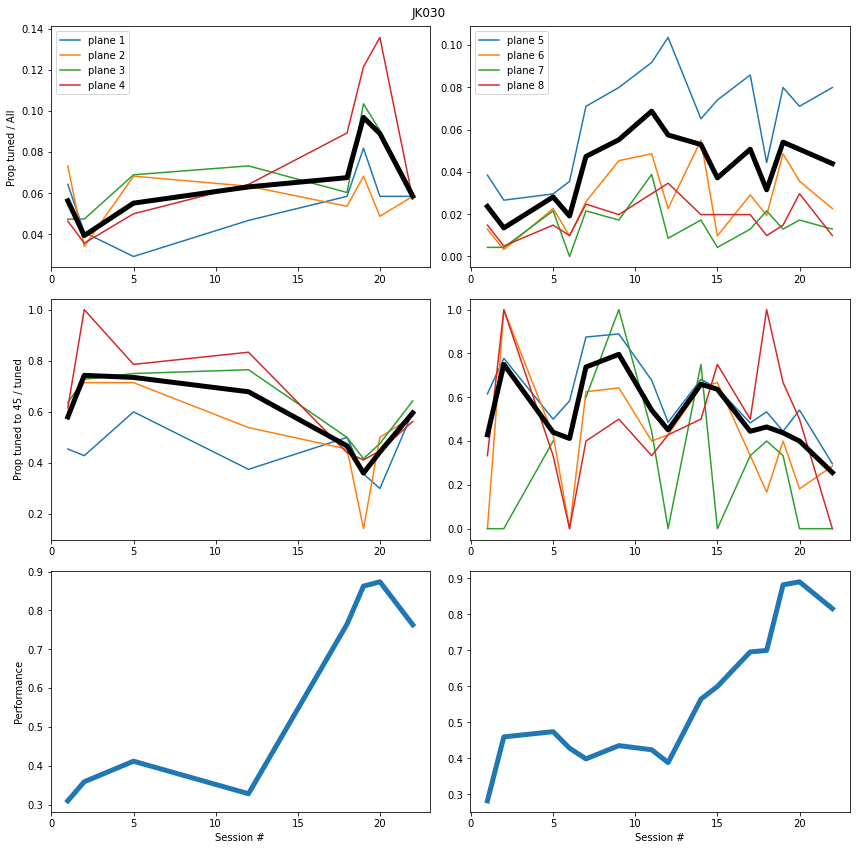

In [11]:
# Plot proportion change across training
# Per plane, within a volume
mouse = 30

cmap = mpl.cm.get_cmap('turbo')
p_threshold_tuned = 0.05
fig, ax = plt.subplots(3,2,figsize=(12,12))
planes = range(1,9)
session_nums_plane = []
num_roi_plane = []
num_tuned_plane = []
num_45_tuned_plane = []
num_touch_response_plane = []
for plane in planes:
    ax_col = 0 if plane < 5 else 1
    load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
    tr_crude = pd.read_pickle(save_dir_base / load_fn)
    session_nums = tr_crude.session.values
    session_nums_plane.append(session_nums)
    p_tuned, effect_tuned = calculate_tuned_response(tr_crude)
    
    num_sessions, num_rois = p_tuned.shape
    num_roi_plane.append(num_rois)

    len_touch_response = tr_crude.p_pre_answer.apply(lambda x: len(np.where(x < 0.01)[0])).values
    num_touch_response_plane.append(len_touch_response)

    len_tuned = np.zeros((num_sessions,))
    len_45_tuned = np.zeros((num_sessions,))
    prop_tuned = np.zeros((num_sessions,))
    prop_45_tuned = np.zeros((num_sessions,))
    prop_135_tuned = np.zeros((num_sessions,))
    for si in range(num_sessions):
        ind_tuned = np.where(p_tuned[si,:]<p_threshold_tuned)[0]
        len_tuned[si] = len(ind_tuned)

        ind_45_tuned = np.where(effect_tuned[si,ind_tuned]>0)[0]
        len_45_tuned[si] = len(ind_45_tuned)
        ind_135_tuned = np.where(effect_tuned[si,ind_tuned]<0)[0]
        prop_tuned[si] = len(ind_tuned) / num_rois
        if len(ind_tuned)>0:
            prop_45_tuned[si] = len(ind_45_tuned) / len(ind_tuned)
        else:
            prop_45_tuned[si] = np.nan
        # prop_135_tuned[si] = len(ind_135_tuned) / len(ind_tuned)
    num_tuned_plane.append(len_tuned)
    num_45_tuned_plane.append(len_45_tuned)
    

    ax[0,ax_col].plot(session_nums, prop_tuned, label=f'plane {plane}')
    ax[1,ax_col].plot(session_nums, prop_45_tuned, label=f'plane {plane}')

    if plane == 1:
        ax[2,0].plot(session_nums, tr_crude.correct_rate.values, linewidth=5)
    elif plane == 5:
        ax[2,1].plot(session_nums, tr_crude.correct_rate.values, linewidth=5)
for ai in range(2):
    ax[0,ai].legend()
    ax[2,ai].set_xlabel('Session #')
ax[0,0].set_ylabel('Prop tuned / All')
ax[1,0].set_ylabel('Prop tuned to 45 / tuned')
ax[2,0].set_ylabel('Performance')

fig.suptitle(f'JK{mouse:03d}')
fig.tight_layout()

# Add volume mean data
for i in range(4):
    if i == 0:
        num_tuned = num_tuned_plane[i]
        num_45_tuned = num_45_tuned_plane[i]
    else:
        num_tuned = np.vstack((num_tuned, num_tuned_plane[i]))
        num_45_tuned = np.vstack((num_45_tuned, num_45_tuned_plane[i]))
mean_prop_tuned = np.sum(num_tuned,axis=0) / np.sum(num_roi_plane[:4])
mean_prop_45_tuned = np.sum(num_45_tuned, axis=0) / np.sum(num_tuned,axis=0)
ax[0,0].plot(session_nums_plane[0], mean_prop_tuned, 'k-', linewidth=5)
ax[1,0].plot(session_nums_plane[0], mean_prop_45_tuned, 'k-', linewidth=5)

for i in range(4,8):
    if i == 4:
        num_tuned = num_tuned_plane[i]
        num_45_tuned = num_45_tuned_plane[i]
    else:
        num_tuned = np.vstack((num_tuned, num_tuned_plane[i]))
        num_45_tuned = np.vstack((num_45_tuned, num_45_tuned_plane[i]))
mean_prop_tuned = np.sum(num_tuned,axis=0) / np.sum(num_roi_plane[:4])
mean_prop_45_tuned = np.sum(num_45_tuned, axis=0) / np.sum(num_tuned,axis=0)
ax[0,1].plot(session_nums_plane[4], mean_prop_tuned, 'k-', linewidth=5)
ax[1,1].plot(session_nums_plane[4], mean_prop_45_tuned, 'k-', linewidth=5)



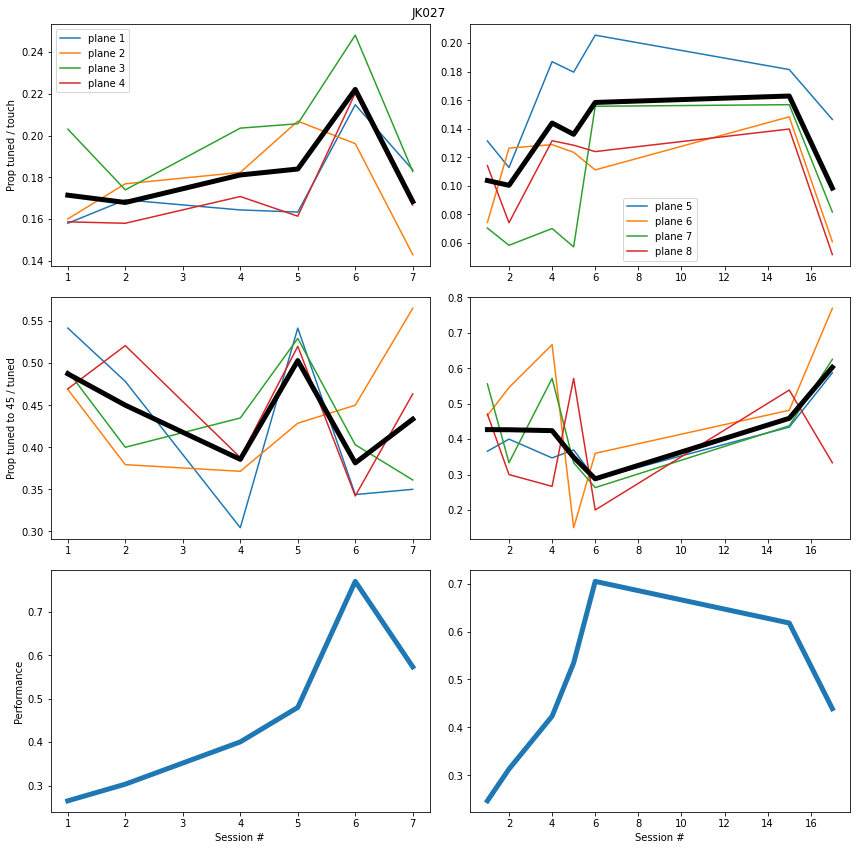

In [6]:
# Prop tuned PER touch neurons

# Plot proportion change across training
# Per plane, within a volume

def plot_tuning_prop_touch_with_behav(mouse):
    cmap = mpl.cm.get_cmap('turbo')
    p_threshold_tuned = 0.05
    fig, ax = plt.subplots(3,2,figsize=(12,12))
    planes = range(1,9)
    session_nums_plane = []
    num_roi_plane = []
    num_tuned_plane = []
    num_45_tuned_plane = []
    num_touch_response_plane = []
    for plane in planes:
        ax_col = 0 if plane < 5 else 1
        load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
        tr_crude = pd.read_pickle(save_dir_base / load_fn)
        session_nums = tr_crude.session.values
        session_nums_plane.append(session_nums)
        p_tuned, effect_tuned = calculate_tuned_response(tr_crude)
        
        num_sessions, num_rois = p_tuned.shape
        num_roi_plane.append(num_rois)

        len_touch_response = tr_crude.p_pre_answer.apply(lambda x: len(np.where(x < 0.01)[0])).values
        num_touch_response_plane.append(len_touch_response)

        len_tuned = np.zeros((num_sessions,))
        len_45_tuned = np.zeros((num_sessions,))
        prop_tuned = np.zeros((num_sessions,))
        prop_45_tuned = np.zeros((num_sessions,))
        prop_135_tuned = np.zeros((num_sessions,))
        for si in range(num_sessions):
            ind_tuned = np.where(p_tuned[si,:]<p_threshold_tuned)[0]
            len_tuned[si] = len(ind_tuned)

            ind_45_tuned = np.where(effect_tuned[si,ind_tuned]>0)[0]
            len_45_tuned[si] = len(ind_45_tuned)
            ind_135_tuned = np.where(effect_tuned[si,ind_tuned]<0)[0]
            prop_tuned[si] = len(ind_tuned) / len_touch_response[si]
            if len(ind_tuned)>0:
                prop_45_tuned[si] = len(ind_45_tuned) / len(ind_tuned)
            else:
                prop_45_tuned[si] = np.nan
            # prop_135_tuned[si] = len(ind_135_tuned) / len(ind_tuned)
        num_tuned_plane.append(len_tuned)
        num_45_tuned_plane.append(len_45_tuned)
        

        ax[0,ax_col].plot(session_nums, prop_tuned, label=f'plane {plane}')
        ax[1,ax_col].plot(session_nums, prop_45_tuned, label=f'plane {plane}')

        if plane == 1:
            ax[2,0].plot(session_nums, tr_crude.correct_rate.values, linewidth=5)
        elif plane == 5:
            ax[2,1].plot(session_nums, tr_crude.correct_rate.values, linewidth=5)
    for ai in range(2):
        ax[0,ai].legend()
        ax[2,ai].set_xlabel('Session #')
    ax[0,0].set_ylabel('Prop tuned / touch')
    ax[1,0].set_ylabel('Prop tuned to 45 / tuned')
    ax[2,0].set_ylabel('Performance')

    fig.suptitle(f'JK{mouse:03d}')
    fig.tight_layout()

    # Add volume mean data
    for i in range(4):
        if i == 0:
            num_tuned = num_tuned_plane[i]
            num_45_tuned = num_45_tuned_plane[i]
            num_touch = num_touch_response_plane[i]
        else:
            num_tuned = np.vstack((num_tuned, num_tuned_plane[i]))
            num_45_tuned = np.vstack((num_45_tuned, num_45_tuned_plane[i]))
            num_touch = np.vstack((num_touch, num_touch_response_plane[i]))
    mean_prop_tuned = np.sum(num_tuned,axis=0) / np.sum(num_touch, axis=0)
    mean_prop_45_tuned = np.sum(num_45_tuned, axis=0) / np.sum(num_tuned,axis=0)
    ax[0,0].plot(session_nums_plane[0], mean_prop_tuned, 'k-', linewidth=5)
    ax[1,0].plot(session_nums_plane[0], mean_prop_45_tuned, 'k-', linewidth=5)

    for i in range(4,8):
        if i == 4:
            num_tuned = num_tuned_plane[i]
            num_45_tuned = num_45_tuned_plane[i]
            num_touch = num_touch_response_plane[i]
        else:
            num_tuned = np.vstack((num_tuned, num_tuned_plane[i]))
            num_45_tuned = np.vstack((num_45_tuned, num_45_tuned_plane[i]))
            num_touch = np.vstack((num_touch, num_touch_response_plane[i]))
    mean_prop_tuned = np.sum(num_tuned,axis=0) / np.sum(num_touch, axis=0)
    mean_prop_45_tuned = np.sum(num_45_tuned, axis=0) / np.sum(num_tuned,axis=0)
    ax[0,1].plot(session_nums_plane[4], mean_prop_tuned, 'k-', linewidth=5)
    ax[1,1].plot(session_nums_plane[4], mean_prop_45_tuned, 'k-', linewidth=5)

    return fig

mouse = 27
fig = plot_tuning_prop_touch_with_behav(mouse)





In [31]:
for mi in range(3):
    mouse = expert_mice[mi]
    fig = plot_tuning_prop_touch_with_behav(mouse)
    save_dir = save_dir_base / 'prop_tuned_over_touch'
    save_dir.mkdir(exist_ok=True, parents=True)
    save_fn = f'JK{mouse:03d}_prop_tuned_over_touch.png'
    fig.savefig(save_dir / save_fn, dpi=300, bbox_inches='tight', transparent=False, facecolor='w')
    plt.close(fig)

# Control the p-value with the # of samples.
- p-values are affected by the # of samples
- Need to control the # of samples.
- Check the minimum # of samples per session, for 135 and 45 touch trials.
- Across all mice.
- Keep the same # of samples.
- Bootstrap 100 times and take the mean. Both for the p-value and response amplitude.
- (Control) Compare the bootstrapped mean amplitude with the whole-sample response amplitude.


In [4]:
# In one plane
mouse = 25
plane = 3
# Check the # of touch trials
load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
tr_crude = pd.read_pickle(save_dir_base / load_fn)


In [3]:
tr_crude.keys()

Index(['session', 'num_roi', 'correct_rate', 'num_answer', 'num_touch_trials',
       'pre_pole_len', 'angle', 'correct', 'num_touch_pre_answer',
       'num_touch_post_answer', 'p_pre_answer', 'p_post_answer',
       'effect_size_pre_answer', 'effect_size_post_answer',
       'effect_size_post_pre', 'pre_pole_activity', 'pre_answer_response',
       'post_answer_response', 'post_pole_activity'],
      dtype='object')

In [5]:
mouse = 25
volume = 0
if volume == 0:
    plane_list = [1,2,3,4]
else:
    plane_list = [5,6,7,8]

for pi, plane in enumerate(plane_list):
    load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
    tr_crude = pd.read_pickle(save_dir_base / load_fn)
    if pi == 0:
        session_nums = tr_crude.session.values
        # make a dictionary of lists using session_nums as keys
        num_touch_pre_answer_45 = {session_num: [] for session_num in session_nums}
        num_touch_pre_answer_135 = {session_num: [] for session_num in session_nums}
        num_touch_post_answer_45 = {session_num: [] for session_num in session_nums}
        num_touch_post_answer_135 = {session_num: [] for session_num in session_nums}

    for _, row in tr_crude.iterrows():
        session_num = row['session']
        num_touch_pre_answer = row['num_touch_pre_answer']
        num_touch_trial_ind = np.where(np.isfinite(num_touch_pre_answer))[0]
        num_touch_post_answer = row['num_touch_post_answer']

        trial_ind_45 = np.intersect1d(np.where(row['angle']==45)[0], num_touch_trial_ind)
        trial_ind_135 = np.intersect1d(np.where(row['angle']==135)[0], num_touch_trial_ind)

        num_touch_pre_answer_45[session_num].append(len(np.where(num_touch_pre_answer[trial_ind_45]>0)[0]))
        num_touch_pre_answer_135[session_num].append(len(np.where(num_touch_pre_answer[trial_ind_135]>0)[0]))
        num_touch_post_answer_45[session_num].append(len(np.where(num_touch_post_answer[trial_ind_45]>0)[0]))
        num_touch_post_answer_135[session_num].append(len(np.where(num_touch_post_answer[trial_ind_135]>0)[0]))

    

In [6]:
num_touch_pre_answer_45

{1: [39, 39, 39, 39],
 2: [165, 165, 165, 165],
 3: [79, 79, 79, 78],
 5: [73, 73, 72, 74],
 6: [54, 54, 54, 54],
 13: [150, 150, 150, 150],
 15: [110, 110, 110, 110],
 17: [85, 85, 85, 85],
 22: [78, 78, 78, 78]}

### Number of touch trials differ among planes in a volume
- Check why this could happen, correct, and save different pickle files
- Now all necessary data (for JK025, 027, 030) are in the DropBox Data folder

In [7]:
def get_touch_responses(wb_df, events_zscore, trial_start_buffer_frame=3):
    correct_rate, num_answer, answer_rate = calculate_correct_rate(wb_df)
            
    trial_nums = wb_df.trialNum.unique()
    num_trials = len(trial_nums)
    pre_pole_activity = []
    pre_answer_response = []
    post_answer_response = []
    post_pole_activity = []
    pre_pole_length = []
    angle = []
    correct = []
    num_pre_answer_touch = []
    num_post_answer_touch = []
    num_touch_trial = 0
    touch_trial_nums = []

    num_cell = events_zscore.shape[1]
    nan_array = np.empty(num_cell)
    nan_array[:] = np.nan
    for ti, trial_num in enumerate(trial_nums):
        trial_wb_df = wb_df[wb_df.trialNum == trial_num]        
        if (not trial_wb_df.iloc[0].miss) and (np.nansum(trial_wb_df.touch_count.values) > 0): # only when there was an answer and at least one touch
            num_touch_trial += 1
            touch_trial_nums.append(trial_num)

            angle.append(trial_wb_df.iloc[0].pole_angle)
            correct.append(trial_wb_df.iloc[0].correct)
            
            trial_events_zscore = events_zscore[np.where(wb_df.trialNum == trial_num)[0],:]
            if len(np.where(trial_wb_df.pole_moving_frame.values)[0]) > 0:
                first_pole_moving_ind = min(np.where(trial_wb_df.pole_up_frame.values)[0][0], np.where(trial_wb_df.pole_moving_frame.values)[0][0])
            else:
                first_pole_moving_ind = np.where(trial_wb_df.pole_up_frame.values)[0][0]
            pre_pole_inds = range(trial_start_buffer_frame,first_pole_moving_ind)
            pre_pole_length.append(len(pre_pole_inds))
            pre_answer_pole_inds = range(np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][0], np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][-1] +2)
            pre_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[pre_answer_pole_inds])

            post_answer_pole_inds = np.where(trial_wb_df.post_answer_pole_up_frame.values)[0] # last frame should be included
            post_pole_inds = []
            
            if len(post_answer_pole_inds) > 0:
                assert post_answer_pole_inds[0] - pre_answer_pole_inds[-1] == 1
                post_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[post_answer_pole_inds])
                if len(trial_wb_df) > post_answer_pole_inds[-1]:
                    post_pole_inds = range(post_answer_pole_inds[-1]+1, len(trial_wb_df))
            else:
                post_answer_num_touch = 0
            
            num_pre_answer_touch.append(pre_answer_num_touch)
            num_post_answer_touch.append(post_answer_num_touch)

            assert len(np.intersect1d(pre_pole_inds, pre_answer_pole_inds))==0
            assert len(np.intersect1d(pre_answer_pole_inds, post_answer_pole_inds))==0
            
            pre_pole_activity.append(np.mean(trial_events_zscore[pre_pole_inds, :], axis=0))
            
            if pre_answer_num_touch > 0:
                pre_answer_response.append(np.mean(trial_events_zscore[pre_answer_pole_inds,:], axis=0) / pre_answer_num_touch)
            else:
                pre_answer_response.append(nan_array)
            if post_answer_num_touch > 0:
                post_answer_response.append(np.mean(trial_events_zscore[post_answer_pole_inds,:], axis=0) / post_answer_num_touch)
            else:
                post_answer_response.append(nan_array)
            if len(post_pole_inds) > 0:
                post_pole_activity.append(np.mean(trial_events_zscore[post_pole_inds, :], axis=0))
            else:
                post_pole_activity.append(nan_array)
           
    return pre_pole_activity, pre_answer_response, post_answer_response, post_pole_activity, \
        num_pre_answer_touch, num_post_answer_touch, touch_trial_nums, \
        pre_pole_length, angle, correct, num_trials

In [44]:
session_num=4
wb_pkl_fn = f'JK{mouse:03d}_S{session_num:02d}_plane{plane}_frame_whisker_behavior.pkl'
plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
wb_df = pd.read_pickle(plane_dir / wb_pkl_fn)

In [30]:
wb_df.keys()

Index(['trialNum', 'frame_start_time', 'frame_end_time', 'trial_duration',
       'frame_index', 'kappaH_onset', 'kappaV_onset', 'phi_onset',
       'theta_onset', 'arc_length_onset', 'touch_count', 'delta_kappaH',
       'delta_kappaV', 'delta_phi', 'delta_theta', 'slide_distance',
       'touch_duration', 'pole_up_frame', 'pole_moving_frame', 'pole_angle',
       'pole_ap_distance', 'pole_radial_distance', 'num_lick_left',
       'num_lick_right', 'answer_lick_frame', 'answer_lick_left',
       'answer_lick_right', 'pre_answer_pole_up_frame', 'answer_period_frame',
       'post_answer_pole_up_frame', 'first_reward_lick_frame',
       'first_reward_lick_left', 'first_reward_lick_right', 'correct', 'wrong',
       'miss', 'trial_type', 'task_target', 'distractor', 'mouse_name',
       'session_name', 'session_type'],
      dtype='object')

In [45]:
wb_df.task_target.unique()

array(['Angle-Discrete'], dtype=object)

In [9]:
mouse = 25
volume = 0
if volume == 0:
    plane_list = [1,2,3,4]
else:
    plane_list = [5,6,7,8]

trial_start_buffer_frame = 3 # to prevent abrupt increase of signal by laser on after ITI and possible contamination by trial start cue

plane_volume = []
session_volume = []
pre_pole_activity_volume = []
pre_answer_response_volume = []
post_answer_response_volume = []
post_pole_activity_volume = []
num_pre_answer_touch_volume = []
num_post_answer_touch_volume = []
touch_trial_nums_volume = []
pre_pole_length_volume = []
angle_volume = []
correct_volume = []
num_trials_volume = []
num_cells_volume = []

touch_trial_nums_all = []
for i, plane in enumerate(plane_list):
    plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
    if i == 0:
        sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
        session_nums = sts_reg['selected_session_num']
    
    session_num = session_nums[0]
    session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
    iscell = np.load(session_roi_dir / 'iscell.npy', allow_pickle=True)[:,0] # Same for all sessions in a plane
    iscell_ind = np.where(iscell)[0]
    num_cell = len(iscell_ind)
    num_rois = len(iscell)

    touch_trial_nums_plane = []
    for session_num in session_nums:
        session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
        
        session_plane_info = f'JK{mouse:03d} S{session_num:02d} plane{plane}'
        print(f'Processing {session_plane_info}')

        events = np.load(session_roi_dir / 'spks.npy', allow_pickle=True).transpose() # To make each cell in each column, and column-direction matches with whisker-behavior dataFrame.
        assert events.shape[1] == num_rois  # Sanity check
        events_zscore = (events - np.mean(events, axis=0)) / np.std(events, axis=0)
        events_zscore = events_zscore[:,iscell_ind]

        wb_pkl_fn = f'JK{mouse:03d}_S{session_num:02d}_plane{plane}_frame_whisker_behavior.pkl'
        if os.path.isfile(plane_dir / wb_pkl_fn):
            wb_df = pd.read_pickle(plane_dir / wb_pkl_fn)
            if wb_df.task_target.values[-1] == 'Angle': # 2-angle training sessions only
                if np.nansum(wb_df.touch_count.values) > 0: # removing whisker-less sessions
                    pre_pole_activity, pre_answer_response, post_answer_response, post_pole_activity, \
                        num_pre_answer_touch, num_post_answer_touch, touch_trial_nums, \
                        pre_pole_length, angle, correct, num_trials = \
                            get_touch_responses(wb_df, events_zscore)
                    touch_trial_nums_plane.append(touch_trial_nums)
            
                    plane_volume.append(plane)
                    session_volume.append(session_num)
                    pre_pole_activity_volume.append(pre_pole_activity)
                    pre_answer_response_volume.append(pre_answer_response)
                    post_answer_response_volume.append(post_answer_response)
                    post_pole_activity_volume.append(post_pole_activity)
                    num_pre_answer_touch_volume.append(num_pre_answer_touch)
                    num_post_answer_touch_volume.append(num_post_answer_touch)
                    pre_pole_length_volume.append(pre_pole_length)
                    angle_volume.append(angle)
                    correct_volume.append(correct)
                    touch_trial_nums_volume.append(touch_trial_nums)
                    num_trials_volume.append(num_trials)
                    num_cells_volume.append(num_cell)

    touch_trial_nums_all.append(touch_trial_nums_plane)
tr_volume = pd.DataFrame({'plane': plane_volume,
                        'session': session_volume,
                        'pre_pole_activity': pre_pole_activity_volume,
                        'pre_answer_response': pre_answer_response_volume,
                        'post_answer_response': post_answer_response_volume,
                        'post_pole_activity': post_pole_activity_volume,
                        'num_pre_answer_touch': num_pre_answer_touch_volume,
                        'num_post_answer_touch': num_post_answer_touch_volume,
                        'pre_pole_length': pre_pole_length_volume,
                        'angle': angle_volume,
                        'correct': correct_volume,
                        'touch_trial_nums': touch_trial_nums_volume,
                        'num_trials': num_trials_volume,
                        'num_cells': num_cells_volume})
save_fn = f'JK{mouse:03d}_volume{volume}_touch_response.pkl'
tr_volume.to_pickle(save_dir_base / save_fn)

[[len(x) for x in y] for y in touch_trial_nums_all]                 

Processing JK025 S01 plane1
Processing JK025 S02 plane1
Processing JK025 S03 plane1
Processing JK025 S04 plane1
Processing JK025 S05 plane1
Processing JK025 S06 plane1
Processing JK025 S13 plane1
Processing JK025 S15 plane1
Processing JK025 S17 plane1
Processing JK025 S19 plane1
Processing JK025 S22 plane1
Processing JK025 S23 plane1
Processing JK025 S24 plane1
Processing JK025 S01 plane2
Processing JK025 S02 plane2
Processing JK025 S03 plane2
Processing JK025 S04 plane2
Processing JK025 S05 plane2
Processing JK025 S06 plane2
Processing JK025 S13 plane2
Processing JK025 S15 plane2
Processing JK025 S17 plane2
Processing JK025 S19 plane2
Processing JK025 S22 plane2
Processing JK025 S23 plane2
Processing JK025 S24 plane2
Processing JK025 S01 plane3
Processing JK025 S02 plane3
Processing JK025 S03 plane3
Processing JK025 S04 plane3
Processing JK025 S05 plane3
Processing JK025 S06 plane3
Processing JK025 S13 plane3
Processing JK025 S15 plane3
Processing JK025 S17 plane3
Processing JK025 S19

[[86, 243, 167, 247, 164, 124, 288, 218, 188, 181, 150],
 [86, 243, 167, 247, 164, 124, 288, 218, 188, 181, 150],
 [86, 243, 167, 247, 164, 124, 288, 218, 188, 181, 150],
 [86, 243, 167, 247, 164, 124, 288, 218, 188, 181, 150]]

In [85]:
events.shape[1] 

173

In [86]:
num_cell

172

In [10]:
row = tr_volume.iloc[0]
for keys in row.keys():
    try:
        print(keys, row[keys].shape)
    except:
        print(keys, len(row[keys]))


plane ()
session ()
pre_pole_activity 86
pre_answer_response 86
post_answer_response 86
post_pole_activity 86
num_pre_answer_touch 86
num_post_answer_touch 86
pre_pole_length 86
angle 86
correct 86
touch_trial_nums 86
num_trials ()
num_cells ()


In [11]:
session_nums = tr_volume.session.unique()
# make a dictionary of lists using session_nums as keys
num_touch_pre_answer_45 = {session_num: [] for session_num in session_nums}
num_touch_pre_answer_135 = {session_num: [] for session_num in session_nums}
num_touch_post_answer_45 = {session_num: [] for session_num in session_nums}
num_touch_post_answer_135 = {session_num: [] for session_num in session_nums}

for plane in plane_list:
    tr_plane = tr_volume[tr_volume.plane == plane]
    for _, row in tr_plane.iterrows():
        session_num = row['session']
        trial_ind_45 = np.where(np.array(row['angle']) == 45)[0]
        trial_ind_135 = np.where(np.array(row['angle']) == 135)[0]
        num_touch_pre_answer_45[session_num].append(len(np.intersect1d(np.where(np.array(row['num_pre_answer_touch']) > 0)[0], trial_ind_45)))
        num_touch_pre_answer_135[session_num].append(len(np.intersect1d(np.where(np.array(row['num_pre_answer_touch']) > 0)[0], trial_ind_135)))
        num_touch_post_answer_45[session_num].append(len(np.intersect1d(np.where(np.array(row['num_post_answer_touch']) > 0)[0], trial_ind_45)))
        num_touch_post_answer_135[session_num].append(len(np.intersect1d(np.where(np.array(row['num_post_answer_touch']) > 0)[0], trial_ind_135)))


In [94]:
num_touch_pre_answer_45

{1: [39, 39, 39, 39],
 2: [165, 165, 165, 165],
 3: [79, 79, 79, 78],
 4: [24, 24, 24, 24],
 5: [73, 73, 72, 74],
 6: [54, 54, 54, 54],
 13: [150, 150, 150, 150],
 15: [110, 110, 110, 110],
 17: [85, 85, 85, 85],
 19: [18, 18, 18, 18],
 22: [78, 78, 78, 78]}

In [96]:
session_num = 5
tr_session = tr_volume[tr_volume.session == session_num]
tr_session

,plane,session,pre_pole_activity,pre_answer_response,post_answer_response,post_pole_activity,num_pre_answer_touch,num_post_answer_touch,pre_pole_length,angle,correct,touch_trial_nums,num_trials,num_cells
4,1,5,"[[0.18787637, -0.12990323, 0.022794867, 5.1494...","[[-0.17109346, -0.12990321, -0.11549863, 0.579...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[1.0, 7.0, 2.0, 1.0, 5.0, 1.0, 0.0, 6.0, 0.0, ...","[0, 4.0, 0, 0, 6.0, 4.0, 2.0, 0, 7.0, 0, 6.0, ...","[5, 5, 5, 5, 5, 4, 4, 5, 4, 5, 5, 4, 5, 4, 5, ...","[45, 135, 45, 45, 135, 135, 135, 45, 45, 45, 4...","[False, True, False, False, True, True, True, ...","[6, 7, 8, 9, 10, 11, 13, 14, 16, 18, 20, 21, 2...",209,155
15,2,5,"[[-0.21402991, -0.24696538, -0.11433516, 0.056...","[[-0.21402992, -0.2469654, -0.11433517, -0.184...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[-0.09319372, -0.20830986, -0.11433517, -0.18...","[1.0, 9.0, 2.0, 1.0, 5.0, 1.0, 0.0, 6.0, 0.0, ...","[0.0, 2.0, 0, 0, 6.0, 4.0, 2.0, 0.0, 7.0, 0, 6...","[5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 6, 5, 5, 5, 5, ...","[45, 135, 45, 45, 135, 135, 135, 45, 45, 45, 4...","[False, True, False, False, True, True, True, ...","[6, 7, 8, 9, 10, 11, 13, 14, 16, 18, 20, 21, 2...",209,172
26,3,5,"[[-0.08631792, 0.12726381, 0.14843845, -0.1615...","[[0.09485045, -0.15750805, 0.22010972, 0.01100...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[1.0, 9.0, 2.0, 1.0, 4.0, 1.0, 0.0, 6.0, 0.0, ...","[0, 2.0, 0, 0.0, 7.0, 4.0, 2.0, 0.0, 7.0, 0, 6...","[5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, ...","[45, 135, 45, 45, 135, 135, 135, 45, 45, 45, 4...","[False, True, False, False, True, True, True, ...","[6, 7, 8, 9, 10, 11, 13, 14, 16, 18, 20, 21, 2...",209,254
37,4,5,"[[-0.19370705, -0.15407316, -0.16448708, -0.19...","[[-0.26693186, -0.15407315, 0.0023437738, 0.23...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[1.0, 7.0, 2.0, 1.0, 3.0, 2.0, 0.0, 6.0, 0.0, ...","[0, 4.0, 0.0, 0, 8.0, 3.0, 2.0, 0, 7.0, 0.0, 5...","[6, 6, 5, 6, 6, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, ...","[45, 135, 45, 45, 135, 135, 135, 45, 45, 45, 4...","[False, True, False, False, True, True, True, ...","[6, 7, 8, 9, 10, 11, 13, 14, 16, 18, 20, 21, 2...",209,247


### Number of touches differ between planes, due to time delays between planes.


In [157]:
session_nums

array([ 1,  2,  3,  4,  5,  6,  7, 25], dtype=int32)

In [161]:
wb_df.pole_angle.unique()

array([ 45, 135], dtype=uint16)

In [37]:
# Make volume-wise touch response dataframe
# Without p-value calculation.
for emi in range(3):
    mouse = expert_mice[emi]
    for volume in [0,1]:
        if volume == 0:
            plane_list = [1,2,3,4]
        else:
            plane_list = [5,6,7,8]

        trial_start_buffer_frame = 3 # to prevent abrupt increase of signal by laser on after ITI and possible contamination by trial start cue

        plane_volume = []
        session_volume = []
        pre_pole_activity_volume = []
        pre_answer_response_volume = []
        post_answer_response_volume = []
        post_pole_activity_volume = []
        num_pre_answer_touch_volume = []
        num_post_answer_touch_volume = []
        touch_trial_nums_volume = []
        pre_pole_length_volume = []
        angle_volume = []
        correct_volume = []
        num_trials_volume = []
        num_cells_volume = []

        touch_trial_nums_all = []
        for i, plane in enumerate(plane_list):
            plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
            if i == 0:
                sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
                session_nums = np.asarray(sts_reg['selected_session_num'])
                session_nums = session_nums[np.where(session_nums<100)[0]] # removing pre sessions
            
            session_num = session_nums[0]
            session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
            iscell = np.load(session_roi_dir / 'iscell.npy', allow_pickle=True)[:,0] # Same for all sessions in a plane
            iscell_ind = np.where(iscell)[0]
            num_cell = len(iscell_ind)
            num_rois = len(iscell)

            touch_trial_nums_plane = []
            for session_num in session_nums:
                session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
                
                session_plane_info = f'JK{mouse:03d} S{session_num:02d} plane{plane}'
                print(f'Processing {session_plane_info}')

                events = np.load(session_roi_dir / 'spks.npy', allow_pickle=True).transpose() # To make each cell in each column, and column-direction matches with whisker-behavior dataFrame.
                assert events.shape[1] == num_rois  # Sanity check
                events_zscore = (events - np.mean(events, axis=0)) / np.std(events, axis=0)
                events_zscore = events_zscore[:,iscell_ind]

                wb_pkl_fn = f'JK{mouse:03d}_S{session_num:02d}_plane{plane}_frame_whisker_behavior.pkl'
                if os.path.isfile(plane_dir / wb_pkl_fn):
                    wb_df = pd.read_pickle(plane_dir / wb_pkl_fn)
                    if wb_df.task_target.values[-1] == 'Angle': # 2-angle training sessions only, otherwise, it is Angle-Discrete
                        if np.nansum(wb_df.touch_count.values) > 0: # removing whisker-less sessions
                            if np.all(np.isin([45, 135], wb_df.pole_angle.unique())): # removing sessions without 45 and 135 trials
                                pre_pole_activity, pre_answer_response, post_answer_response, post_pole_activity, \
                                    num_pre_answer_touch, num_post_answer_touch, touch_trial_nums, \
                                    pre_pole_length, angle, correct, num_trials = \
                                        get_touch_responses(wb_df, events_zscore)
                                # touch_trial_nums_plane.append(touch_trial_nums)
                        
                                plane_volume.append(plane)
                                session_volume.append(session_num)
                                pre_pole_activity_volume.append(pre_pole_activity)
                                pre_answer_response_volume.append(pre_answer_response)
                                post_answer_response_volume.append(post_answer_response)
                                post_pole_activity_volume.append(post_pole_activity)
                                num_pre_answer_touch_volume.append(num_pre_answer_touch)
                                num_post_answer_touch_volume.append(num_post_answer_touch)
                                pre_pole_length_volume.append(pre_pole_length)
                                angle_volume.append(angle)
                                correct_volume.append(correct)
                                touch_trial_nums_volume.append(touch_trial_nums)
                                num_trials_volume.append(num_trials)
                                num_cells_volume.append(num_cell)

            # touch_trial_nums_all.append(touch_trial_nums_plane)
        tr_volume = pd.DataFrame({'plane': plane_volume,
                                'session': session_volume,
                                'pre_pole_activity': pre_pole_activity_volume,
                                'pre_answer_response': pre_answer_response_volume,
                                'post_answer_response': post_answer_response_volume,
                                'post_pole_activity': post_pole_activity_volume,
                                'num_pre_answer_touch': num_pre_answer_touch_volume,
                                'num_post_answer_touch': num_post_answer_touch_volume,
                                'pre_pole_length': pre_pole_length_volume,
                                'angle': angle_volume,
                                'correct': correct_volume,
                                'touch_trial_nums': touch_trial_nums_volume,
                                'num_trials': num_trials_volume,
                                'num_cells': num_cells_volume})
        save_fn = f'JK{mouse:03d}_volume{volume}_2angle_touch_response.pkl'
        tr_volume.to_pickle(save_dir_base / save_fn)

Processing JK025 S01 plane1
Processing JK025 S02 plane1
Processing JK025 S03 plane1
Processing JK025 S04 plane1
Processing JK025 S05 plane1
Processing JK025 S06 plane1
Processing JK025 S13 plane1
Processing JK025 S15 plane1
Processing JK025 S17 plane1
Processing JK025 S19 plane1
Processing JK025 S22 plane1
Processing JK025 S23 plane1
Processing JK025 S24 plane1
Processing JK025 S01 plane2
Processing JK025 S02 plane2
Processing JK025 S03 plane2
Processing JK025 S04 plane2
Processing JK025 S05 plane2
Processing JK025 S06 plane2
Processing JK025 S13 plane2
Processing JK025 S15 plane2
Processing JK025 S17 plane2
Processing JK025 S19 plane2
Processing JK025 S22 plane2
Processing JK025 S23 plane2
Processing JK025 S24 plane2
Processing JK025 S01 plane3
Processing JK025 S02 plane3
Processing JK025 S03 plane3
Processing JK025 S04 plane3
Processing JK025 S05 plane3
Processing JK025 S06 plane3
Processing JK025 S13 plane3
Processing JK025 S15 plane3
Processing JK025 S17 plane3
Processing JK025 S19

## p-value controlling
- 100 bootstrapping of 30 trials (45 and 135 each), then take the mean of each trial type.
    - Mean p-values and response amplitudes.
    - Neurons with either 45 or 135 responsiveness are touch neurons.
    - P-values for 45 vs 135 in each bootstrap. Take the mean of those two
- Also calculate response amplitudes without bootstrapping (control - should be similar to the mean of bootstrapping)
- Both for touch responsiveness and tuning.
- Including first/second halves and odd/even numbers, for within-session control.
- Save the result

In [39]:
num_iter = 100
num_samples = 30

p_45_pre = []
p_135_pre = []
p_45_post = []
p_135_post = []
p_45_135_pre = []
p_45_135_post = []
response_amp_45_pre = []
response_amp_135_pre = []
response_amp_45_post = []
response_amp_135_post = []
diff_45_135_pre = []
diff_45_135_post = []
for _, row in tr_volume.iterrows():
    num_cells = row.num_cells

    ind_pre_touch = np.where(np.asarray(row.num_pre_answer_touch) > 0)[0]
    ind_post_touch = np.where(np.asarray(row.num_post_answer_touch) > 0)[0]
    ind_45 = np.where(np.asarray(row.angle) == 45)[0]
    ind_135 = np.where(np.asarray(row.angle) == 135)[0]
    ind_45_pre = np.intersect1d(ind_45, ind_pre_touch)
    ind_135_pre = np.intersect1d(ind_135, ind_pre_touch)
    ind_45_post = np.intersect1d(ind_45, ind_post_touch)
    ind_135_post = np.intersect1d(ind_135, ind_post_touch)

    p_45_pre_iter = np.zeros((num_iter, num_cells))
    p_135_pre_iter = np.zeros((num_iter, num_cells))
    p_45_post_iter = np.zeros((num_iter, num_cells))
    p_135_post_iter = np.zeros((num_iter, num_cells))
    response_amp_45_pre_iter = np.zeros((num_iter, num_cells))
    response_amp_135_pre_iter = np.zeros((num_iter, num_cells))
    response_amp_45_post_iter = np.zeros((num_iter, num_cells))
    response_amp_135_post_iter = np.zeros((num_iter, num_cells))
    p_45_135_pre_iter = np.zeros((num_iter, num_cells))
    p_45_135_post_iter = np.zeros((num_iter, num_cells))
    diff_45_135_pre_iter = np.zeros((num_iter, num_cells))
    diff_45_135_post_iter = np.zeros((num_iter, num_cells))

    pre_pole_activity = np.array(row.pre_pole_activity)
    pre_answer_response = np.array(row.pre_answer_response)
    post_answer_response = np.array(row.post_answer_response)

    assert pre_pole_activity.shape[0] == pre_answer_response.shape[0] == post_answer_response.shape[0]
    assert pre_pole_activity.shape[1] == pre_answer_response.shape[1] == post_answer_response.shape[1]
    assert pre_pole_activity.shape[1] == num_cells
    assert pre_pole_activity.shape[0] == len(row.touch_trial_nums)

    pre_answer_response_subtract = pre_answer_response - pre_pole_activity
    post_answer_response_subtract = post_answer_response - pre_pole_activity

    for i in range(num_iter):
        ind_45_pre_sample = np.random.choice(ind_45_pre, num_samples, replace=True)
        ind_135_pre_sample = np.random.choice(ind_135_pre, num_samples, replace=True)
        ind_45_post_sample = np.random.choice(ind_45_post, num_samples, replace=True)
        ind_135_post_sample = np.random.choice(ind_135_post, num_samples, replace=True)
        _response_amp_45_pre = np.array([pre_answer_response_subtract[ind,:] for ind in ind_45_pre_sample])
        _response_amp_135_pre = np.array([pre_answer_response_subtract[ind,:] for ind in ind_135_pre_sample])
        _response_amp_45_post = np.array([post_answer_response_subtract[ind,:] for ind in ind_45_post_sample])
        _response_amp_135_post = np.array([post_answer_response_subtract[ind,:] for ind in ind_135_post_sample])
        response_amp_45_pre_iter[i,:] = np.mean(_response_amp_45_pre, axis=0)
        response_amp_135_pre_iter[i,:] = np.mean(_response_amp_135_pre, axis=0)
        response_amp_45_post_iter[i,:] = np.mean(_response_amp_45_post, axis=0)
        response_amp_135_post_iter[i,:] = np.mean(_response_amp_135_post, axis=0)
        p_45_pre_iter[i,:] = stats.ttest_1samp(pre_answer_response_subtract[ind_45_pre_sample,:], 0)[1]
        p_135_pre_iter[i,:] = stats.ttest_1samp(pre_answer_response_subtract[ind_135_pre_sample,:], 0)[1]
        p_45_post_iter[i,:] = stats.ttest_1samp(post_answer_response_subtract[ind_45_post_sample,:], 0)[1]
        p_135_post_iter[i,:] = stats.ttest_1samp(post_answer_response_subtract[ind_135_post_sample,:], 0)[1]
        p_45_135_pre_iter[i,:] = stats.ttest_ind(pre_answer_response_subtract[ind_45_pre_sample,:], pre_answer_response_subtract[ind_135_pre_sample,:]).pvalue
        p_45_135_post_iter[i,:] = stats.ttest_ind(post_answer_response_subtract[ind_45_post_sample,:], post_answer_response_subtract[ind_135_post_sample,:]).pvalue
        diff_45_135_pre_iter[i,:] = response_amp_45_pre_iter[i,:] - response_amp_135_pre_iter[i,:]
        diff_45_135_post_iter[i,:] = response_amp_45_post_iter[i,:] - response_amp_135_post_iter[i,:]
    p_45_pre.append(np.mean(p_45_pre_iter, axis=0))
    p_135_pre.append(np.mean(p_135_pre_iter, axis=0))
    p_45_post.append(np.mean(p_45_post_iter, axis=0))
    p_135_post.append(np.mean(p_135_post_iter, axis=0))
    response_amp_45_pre.append(np.mean(response_amp_45_pre_iter, axis=0))
    response_amp_135_pre.append(np.mean(response_amp_135_pre_iter, axis=0))
    response_amp_45_post.append(np.mean(response_amp_45_post_iter, axis=0))
    response_amp_135_post.append(np.mean(response_amp_135_post_iter, axis=0))
    p_45_135_pre.append(np.mean(p_45_135_pre_iter, axis=0))
    p_45_135_post.append(np.mean(p_45_135_post_iter, axis=0))
    diff_45_135_pre.append(np.mean(diff_45_135_pre_iter, axis=0))
    diff_45_135_post.append(np.mean(diff_45_135_post_iter, axis=0))
tr_volume['p_45_pre'] = p_45_pre
tr_volume['p_135_pre'] = p_135_pre
tr_volume['p_45_post'] = p_45_post
tr_volume['p_135_post'] = p_135_post
tr_volume['response_amp_45_pre'] = response_amp_45_pre
tr_volume['response_amp_135_pre'] = response_amp_135_pre
tr_volume['response_amp_45_post'] = response_amp_45_post
tr_volume['response_amp_135_post'] = response_amp_135_post
tr_volume['p_45_135_pre'] = p_45_135_pre
tr_volume['p_45_135_post'] = p_45_135_post
tr_volume['diff_45_135_pre'] = diff_45_135_pre
tr_volume['diff_45_135_post'] = diff_45_135_post

In [8]:
def calc_touch_tune_p_from_tr_volume_df(tr_volume, num_samples=30, num_iter=100):
    p_45_pre = []
    p_135_pre = []
    p_45_post = []
    p_135_post = []
    p_45_135_pre = []
    p_45_135_post = []
    response_amp_45_pre = []
    response_amp_135_pre = []
    response_amp_45_post = []
    response_amp_135_post = []
    diff_45_135_pre = []
    diff_45_135_post = []
    for _, row in tr_volume.iterrows():
        num_cells = row.num_cells

        ind_pre_touch = np.where(np.asarray(row.num_pre_answer_touch) > 0)[0]
        ind_post_touch = np.where(np.asarray(row.num_post_answer_touch) > 0)[0]
        ind_45 = np.where(np.asarray(row.angle) == 45)[0]
        ind_135 = np.where(np.asarray(row.angle) == 135)[0]
        ind_45_pre = np.intersect1d(ind_45, ind_pre_touch)
        ind_135_pre = np.intersect1d(ind_135, ind_pre_touch)
        ind_45_post = np.intersect1d(ind_45, ind_post_touch)
        ind_135_post = np.intersect1d(ind_135, ind_post_touch)

        p_45_pre_iter = np.zeros((num_iter, num_cells))
        p_135_pre_iter = np.zeros((num_iter, num_cells))
        p_45_post_iter = np.zeros((num_iter, num_cells))
        p_135_post_iter = np.zeros((num_iter, num_cells))
        response_amp_45_pre_iter = np.zeros((num_iter, num_cells))
        response_amp_135_pre_iter = np.zeros((num_iter, num_cells))
        response_amp_45_post_iter = np.zeros((num_iter, num_cells))
        response_amp_135_post_iter = np.zeros((num_iter, num_cells))
        p_45_135_pre_iter = np.zeros((num_iter, num_cells))
        p_45_135_post_iter = np.zeros((num_iter, num_cells))
        diff_45_135_pre_iter = np.zeros((num_iter, num_cells))
        diff_45_135_post_iter = np.zeros((num_iter, num_cells))

        pre_pole_activity = np.array(row.pre_pole_activity)
        pre_answer_response = np.array(row.pre_answer_response)
        post_answer_response = np.array(row.post_answer_response)

        assert pre_pole_activity.shape[0] == pre_answer_response.shape[0] == post_answer_response.shape[0]
        assert pre_pole_activity.shape[1] == pre_answer_response.shape[1] == post_answer_response.shape[1]
        assert pre_pole_activity.shape[1] == num_cells
        assert pre_pole_activity.shape[0] == len(row.touch_trial_nums)

        pre_answer_response_subtract = pre_answer_response - pre_pole_activity
        post_answer_response_subtract = post_answer_response - pre_pole_activity

        for i in range(num_iter):
            ind_45_pre_sample = np.random.choice(ind_45_pre, num_samples, replace=True)
            ind_135_pre_sample = np.random.choice(ind_135_pre, num_samples, replace=True)
            ind_45_post_sample = np.random.choice(ind_45_post, num_samples, replace=True)
            ind_135_post_sample = np.random.choice(ind_135_post, num_samples, replace=True)
            _response_amp_45_pre = np.array([pre_answer_response_subtract[ind,:] for ind in ind_45_pre_sample])
            _response_amp_135_pre = np.array([pre_answer_response_subtract[ind,:] for ind in ind_135_pre_sample])
            _response_amp_45_post = np.array([post_answer_response_subtract[ind,:] for ind in ind_45_post_sample])
            _response_amp_135_post = np.array([post_answer_response_subtract[ind,:] for ind in ind_135_post_sample])
            response_amp_45_pre_iter[i,:] = np.mean(_response_amp_45_pre, axis=0)
            response_amp_135_pre_iter[i,:] = np.mean(_response_amp_135_pre, axis=0)
            response_amp_45_post_iter[i,:] = np.mean(_response_amp_45_post, axis=0)
            response_amp_135_post_iter[i,:] = np.mean(_response_amp_135_post, axis=0)
            p_45_pre_iter[i,:] = stats.ttest_1samp(pre_answer_response_subtract[ind_45_pre_sample,:], 0)[1]
            p_135_pre_iter[i,:] = stats.ttest_1samp(pre_answer_response_subtract[ind_135_pre_sample,:], 0)[1]
            p_45_post_iter[i,:] = stats.ttest_1samp(post_answer_response_subtract[ind_45_post_sample,:], 0)[1]
            p_135_post_iter[i,:] = stats.ttest_1samp(post_answer_response_subtract[ind_135_post_sample,:], 0)[1]
            p_45_135_pre_iter[i,:] = stats.ttest_ind(pre_answer_response_subtract[ind_45_pre_sample,:], pre_answer_response_subtract[ind_135_pre_sample,:]).pvalue
            p_45_135_post_iter[i,:] = stats.ttest_ind(post_answer_response_subtract[ind_45_post_sample,:], post_answer_response_subtract[ind_135_post_sample,:]).pvalue
            diff_45_135_pre_iter[i,:] = response_amp_45_pre_iter[i,:] - response_amp_135_pre_iter[i,:]
            diff_45_135_post_iter[i,:] = response_amp_45_post_iter[i,:] - response_amp_135_post_iter[i,:]
        p_45_pre.append(np.mean(p_45_pre_iter, axis=0))
        p_135_pre.append(np.mean(p_135_pre_iter, axis=0))
        p_45_post.append(np.mean(p_45_post_iter, axis=0))
        p_135_post.append(np.mean(p_135_post_iter, axis=0))
        response_amp_45_pre.append(np.mean(response_amp_45_pre_iter, axis=0))
        response_amp_135_pre.append(np.mean(response_amp_135_pre_iter, axis=0))
        response_amp_45_post.append(np.mean(response_amp_45_post_iter, axis=0))
        response_amp_135_post.append(np.mean(response_amp_135_post_iter, axis=0))
        p_45_135_pre.append(np.mean(p_45_135_pre_iter, axis=0))
        p_45_135_post.append(np.mean(p_45_135_post_iter, axis=0))
        diff_45_135_pre.append(np.mean(diff_45_135_pre_iter, axis=0))
        diff_45_135_post.append(np.mean(diff_45_135_post_iter, axis=0))
    tr_volume['p_45_pre'] = p_45_pre
    tr_volume['p_135_pre'] = p_135_pre
    tr_volume['p_45_post'] = p_45_post
    tr_volume['p_135_post'] = p_135_post
    tr_volume['response_amp_45_pre'] = response_amp_45_pre
    tr_volume['response_amp_135_pre'] = response_amp_135_pre
    tr_volume['response_amp_45_post'] = response_amp_45_post
    tr_volume['response_amp_135_post'] = response_amp_135_post
    tr_volume['p_45_135_pre'] = p_45_135_pre
    tr_volume['p_45_135_post'] = p_45_135_post
    tr_volume['diff_45_135_pre'] = diff_45_135_pre
    tr_volume['diff_45_135_post'] = diff_45_135_post
    return tr_volume


In [39]:
for emi in range(3):
    mouse = expert_mice[emi]
    for volume in [0,1]:
        load_fn = f'JK{mouse:03d}_volume{volume}_2angle_touch_response.pkl'
        tr_volume = pd.read_pickle(save_dir_base / load_fn)
        tr_volume = calc_touch_tune_p_from_tr_volume_df(tr_volume)
        save_fn = f'JK{mouse:03d}_volume{volume}_2angle_touch_response_bootstrapped_ttest.pkl'
        tr_volume.to_pickle(save_dir_base / save_fn)

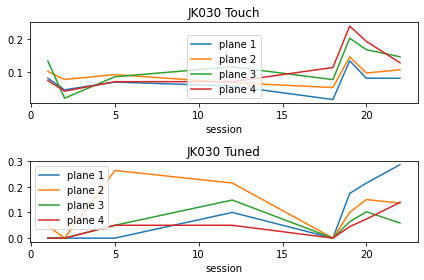

In [14]:
mouse = 30
volume = 0
planes = range(1,5) if volume==0 else range(5,9)

p_threshold = 0.01
load_fn = f'JK{mouse:03d}_volume{volume}_2angle_touch_response_bootstrapped_ttest.pkl'
tr_volume = pd.read_pickle(save_dir_base / load_fn)
tr_volume['ind_touch_45_pre'] = tr_volume.p_45_pre.apply(lambda x: np.where(x < p_threshold)[0])
tr_volume['ind_touch_135_pre'] = tr_volume.p_135_pre.apply(lambda x: np.where(x < p_threshold)[0])
tr_volume['ind_touch_pre'] = tr_volume.apply(lambda x: np.union1d(x.ind_touch_45_pre, x.ind_touch_135_pre), axis=1)
tr_volume['ind_touch_45_post'] = tr_volume.p_45_post.apply(lambda x: np.where(x < p_threshold)[0])
tr_volume['ind_touch_135_post'] = tr_volume.p_135_post.apply(lambda x: np.where(x < p_threshold)[0])
tr_volume['ind_touch_post'] = tr_volume.apply(lambda x: np.union1d(x.ind_touch_45_post, x.ind_touch_135_post), axis=1)
tr_volume['ind_tuned_pre'] = tr_volume.apply(lambda x: np.intersect1d(np.where(x.p_45_135_pre < p_threshold)[0], x.ind_touch_pre), axis=1)
tr_volume['ind_tuned_post'] = tr_volume.apply(lambda x: np.intersect1d(np.where(x.p_45_135_post < p_threshold)[0], x.ind_touch_post), axis=1)
tr_volume['num_touch_pre'] = tr_volume.ind_touch_pre.apply(lambda x: len(x))
tr_volume['num_touch_post'] = tr_volume.ind_touch_post.apply(lambda x: len(x))
tr_volume['num_tuned_pre'] = tr_volume.ind_tuned_pre.apply(lambda x: len(x))
tr_volume['num_tuned_post'] = tr_volume.ind_tuned_post.apply(lambda x: len(x))
tr_volume['prop_touch_pre'] = tr_volume.num_touch_pre / tr_volume.num_cells
tr_volume['prop_touch_post'] = tr_volume.num_touch_post / tr_volume.num_cells
tr_volume['prop_tuned_pre'] = tr_volume.num_tuned_pre / tr_volume.num_touch_pre
tr_volume['prop_tuned_post'] = tr_volume.num_tuned_post / tr_volume.num_touch_post

fig, ax = plt.subplots(2,1)
for plane in planes:
    tr_volume.query('plane == @plane').plot(x='session', y='prop_touch_pre', ax=ax[0], label=f'plane {plane}', title=f'JK{mouse:03d} Touch')
    tr_volume.query('plane == @plane').plot(x='session', y='prop_tuned_pre', ax=ax[1], label=f'plane {plane}', title=f'JK{mouse:03d} Tuned')
fig.tight_layout()

In [46]:
mouse = 25
volume = 0

p_threshold = 0.01
load_fn = f'JK{mouse:03d}_volume{volume}_2angle_touch_response_bootstrapped_ttest.pkl'
tr_volume = pd.read_pickle(save_dir_base / load_fn)
planes = tr_volume['plane'].unique()
num_cells_plane = []
for plane in planes:
    num_cells_plane.append(tr_volume.query('plane == @plane').iloc[0].num_cells)
session_nums = tr_volume['session'].unique()
p_45_pre = []
p_135_pre = []
p_45_post = []
p_135_post = []
response_amp_45_pre = []
response_amp_135_pre = []
response_amp_45_post = []
response_amp_135_postsession = []
p_45_135_pre = []
p_45_135_post = []
diff_45_135_pre = []
diff_45_135_post = []
for session_num in session_nums:
    p_45_pre_session = []
    p_135_pre_session = []
    p_45_post_session = []
    p_135_post_session = []
    response_amp_45_pre_session = []
    response_amp_135_pre_session = []
    response_amp_45_post_session = []
    response_amp_135_post_session = []
    p_45_135_pre_session = []
    p_45_135_post_session = []
    diff_45_135_pre_session = []
    diff_45_135_post_session = []
    for plane in planes:
        ind = np.where((tr_volume['plane']==plane) & (tr_volume['session']==session_num))[0][0]
        row = tr_volume.iloc[ind]
        p_45_pre_session.append(row.p_45_pre)
        p_135_pre_session.append(row.p_135_pre)
        p_45_post_session.append(row.p_45_post)
        p_135_post_session.append(row.p_135_post)
        response_amp_45_pre_session.append(row.response_amp_45_pre)
        response_amp_135_pre_session.append(row.response_amp_135_pre)
        response_amp_45_post_session.append(row.response_amp_45_post)
        response_amp_135_post_session.append(row.response_amp_135_post)
        p_45_135_pre_session.append(row.p_45_135_pre)
        p_45_135_post_session.append(row.p_45_135_post)
        diff_45_135_pre_session.append(row.diff_45_135_pre)
        diff_45_135_post_session.append(row.diff_45_135_post)
    p_45_pre.append(p_45_pre_session)
    p_135_pre.append(p_135_pre_session)
    p_45_post.append(p_45_post_session)
    p_135_post.append(p_135_post_session)
    response_amp_45_pre.append(response_amp_45_pre_session)
    response_amp_135_pre.append(response_amp_135_pre_session)
    response_amp_45_post.append(response_amp_45_post_session)
    response_amp_135_post.append(response_amp_135_post_session)
    p_45_135_pre.append(p_45_135_pre_session)
    p_45_135_post.append(p_45_135_post_session)
    diff_45_135_pre.append(diff_45_135_pre_session)
    diff_45_135_post.append(diff_45_135_post_session)
num_cells_volume = np.sum(num_cells_plane)
    

# Touch response, pre-answer
ind_touch_45_pre_plane = [[np.where(p<p_threshold)[0] for p in p_45] for p_45 in p_45_pre]
ind_touch_45_pre_volume = [np.where(np.concatenate(p)<p_threshold)[0] for p in p_45_pre]
ind_touch_135_pre_plane = [[np.where(p<p_threshold)[0] for p in p_135] for p_135 in p_135_pre]
ind_touch_135_pre_volume = [np.where(np.concatenate(p)<p_threshold)[0] for p in p_135_pre]
# Touch responsive neurons are a union of 45 and 135 touch responsive neurons
ind_touch_pre_plane = [[np.union1d(ind_45, ind_135) for ind_45, ind_135 in zip(ind_45_plane, ind_135_plane)] 
                       for ind_45_plane, ind_135_plane in zip(ind_touch_45_pre_plane, ind_touch_135_pre_plane)]
ind_touch_pre_volume = [np.union1d(ind_45, ind_135) for ind_45, ind_135 
                        in zip(ind_touch_45_pre_volume, ind_touch_135_pre_volume)]
num_touch_pre_plane = [[len(ind) for ind in ind_touch] for ind_touch in ind_touch_pre_plane]
num_touch_pre_volume = [len(ind) for ind in ind_touch_pre_volume]

# Touch response, post-answer
ind_touch_45_post_plane = [[np.where(p<p_threshold)[0] for p in p_45] for p_45 in p_45_post]
ind_touch_45_post_volume = [np.where(np.concatenate(p)<p_threshold)[0] for p in p_45_post]
ind_touch_135_post_plane = [[np.where(p<p_threshold)[0] for p in p_135] for p_135 in p_135_post]
ind_touch_135_post_volume = [np.where(np.concatenate(p)<p_threshold)[0] for p in p_135_post]
ind_touch_post_plane = [[np.union1d(ind_45, ind_135) for ind_45, ind_135 in zip(ind_45_plane, ind_135_plane)]
                        for ind_45_plane, ind_135_plane in zip(ind_touch_45_post_plane, ind_touch_135_post_plane)]
ind_touch_post_volume = [np.union1d(ind_45, ind_135) for ind_45, ind_135
                            in zip(ind_touch_45_post_volume, ind_touch_135_post_volume)]
num_touch_post_plane = [[len(ind) for ind in ind_touch] for ind_touch in ind_touch_post_plane]
num_touch_post_volume = [len(ind) for ind in ind_touch_post_volume]

# Proportion of touch responsive neurons
prop_touch_pre_plane = [num_touch/np.asarray(num_cells_plane) for num_touch in num_touch_pre_plane]
prop_touch_pre_volume = [num_touch/num_cells_volume for num_touch in num_touch_pre_volume]
prop_touch_post_plane = [num_touch/np.asarray(num_cells_plane) for num_touch in num_touch_post_plane]
prop_touch_post_volume = [num_touch/num_cells_volume for num_touch in num_touch_post_volume]

# Tuned neurons must be touch responsive neurons
ind_tuned_pre_plane = [[np.intersect1d(np.where(p<p_threshold)[0], ind_touch) for p, ind_touch in zip(p_45_135, ind_touch_pre)] 
                       for p_45_135, ind_touch_pre in zip(p_45_135_pre, ind_touch_pre_plane)]
ind_tuned_pre_volume = [np.intersect1d(np.where(np.concatenate(p)<p_threshold)[0], ind_touch) 
                        for p, ind_touch in zip(p_45_135_pre, ind_touch_pre_volume)]
ind_tuned_post_plane = [[np.intersect1d(np.where(p<p_threshold)[0], ind_touch) for p, ind_touch in zip(p_45_135, ind_touch_post)] 
                       for p_45_135, ind_touch_post in zip(p_45_135_post, ind_touch_post_plane)]
ind_tuned_post_volume = [np.intersect1d(np.where(np.concatenate(p)<p_threshold)[0], ind_touch)
                         for p, ind_touch in zip(p_45_135_post, ind_touch_post_volume)]

num_tuned_pre_plane = [[len(ind) for ind in ind_tuned] for ind_tuned in ind_tuned_pre_plane]
num_tuned_pre_volume = [len(ind) for ind in ind_tuned_pre_volume]
num_tuned_post_plane = [[len(ind) for ind in ind_tuned] for ind_tuned in ind_tuned_post_plane]
num_tuned_post_volume = [len(ind) for ind in ind_tuned_post_volume]

# Proportion of tuned neurons / touch responsive neurons
prop_tuned_pre_plane = [[num_tuned/num_touch for num_tuned, num_touch in zip(num_tuned_pre, num_touch_pre)]
                        for num_tuned_pre, num_touch_pre in zip(num_tuned_pre_plane, num_touch_pre_plane)]
prop_tuned_pre_volume = [num_tuned/num_touch for num_tuned, num_touch in zip(num_tuned_pre_volume, num_touch_pre_volume)]
prop_tuned_post_plane = [[num_tuned/num_touch for num_tuned, num_touch in zip(num_tuned_post, num_touch_post)]
                        for num_tuned_post, num_touch_post in zip(num_tuned_post_plane, num_touch_post_plane)]
prop_tuned_post_volume = [num_tuned/num_touch for num_tuned, num_touch in zip(num_tuned_post_volume, num_touch_post_volume)]


fig, ax = plt.subplots(2,1,figsize=(10,10))
for i in range(4):
    ax[0].plot(session_nums, [pt[i] for pt in prop_touch_pre_plane], 'o-', label=f'plane{i}')
    ax[1].plot(session_nums, [pt[i] for pt in prop_tuned_post_plane], 'o-', label=f'plane{i}')
ax[0].plot(session_nums, prop_touch_pre_volume, 'ko-', label='mean_pre_answer', linewidth=5)
ax[0].plot(session_nums, prop_touch_post_volume, 'ko-', label='mean_post_answer', alpha=0.5, linewidth=5)
ax[1].plot(session_nums, prop_tuned_pre_volume, 'ko-', label='mean_pre_answer', linewidth=5)
ax[1].plot(session_nums, prop_tuned_post_volume, 'ko-', label='mean_post_answer', alpha=0.5, linewidth=5)
ax[0].legend()
ax[1].legend()
# ax.plot(session_nums, num_touch_pre/num_cells_volume, 'o-', label='45 pre')
# ax.plot(session_nums, num_touch_post/num_cells_volume, 'o-', label='45 post')
# ax.plot(session_nums, num_tuned_pre/num_cells_volume, 'o-', label='tuned pre')
# ax.plot(session_nums, num_tuned_post/num_cells_volume, 'o-', label='tuned post')
# ax.legend()
ax[0].set_title('Touch response neurons')
ax[0].set_ylabel('proportion')
ax[1].set_title('Tuned neurons')
ax[1].set_ylabel('proportion')
ax[1].set_xlabel('session')
fig.suptitle(f'JK{mouse:03d} volume{volume}')
fig.tight_layout()

NameError: name 'response_amp_135_post' is not defined

(454,)

# For QCing individual neuron's touch responsiveness
- p-value < 0.01 (-log(p)>2) seems reasonable choice (based on the proportion)

In [7]:
# Touch response calculation QC
# Per plane in a session


# Per trial touch response
# Pre-answer (including the answer lick frame) and post-answer (starting AFTER the answer lick frame)
# Response amplitue (in terms of z-score)
# Divided by the total # of touches within the window
# Responsiveness, tested by t-test to the values before pole up (up until the first pole moving or pole up frame, whichever is faster)
emi = 2
plane = 1

mouse = expert_mice[emi]
if emi < 3:
    h5_dir = h5_dir_1
else:
    h5_dir = h5_dir_2

plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
session_nums = sts_reg['selected_session_num']

si = 9
session_num = session_nums[si]
session_plane_info = f'JK{mouse:03d} S{session_num:02d} plane{plane}'

# Load events
session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
iscell = np.load(session_roi_dir / 'iscell.npy', allow_pickle=True)[:,0] # Same for all sessions in a plane
events = np.load(session_roi_dir / 'spks.npy', allow_pickle=True).transpose() # To make each cell in each column, and column-direction matches with whisker-behavior dataFrame.
events_zscore = (events - np.mean(events, axis=0)) / np.std(events, axis=0)
print(f'Session {session_num:02d}')
print(events.shape)
print(len(np.where(iscell==1)[0]))
events.shape[1] == len(iscell)


events = events[:,np.where(iscell)[0]]
events_zscore = events_zscore[:,np.where(iscell)[0]]

# load whisker-behavior dataFrame
wb_df = pd.read_pickle(plane_dir / f'JK{mouse:03d}_S{session_num:02d}_plane{plane}_frame_whisker_behavior.pkl')

trial_start_buffer_frame = 3 # to prevent abrupt increase of signal by laser on after ITI and possible contamination by trial start cue
trial_nums = wb_df.trialNum.unique()
pre_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
pre_pole_activity[:] = np.nan
pre_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
pre_answer_response[:] = np.nan
post_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
post_answer_response[:] = np.nan
post_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
post_pole_activity[:] = np.nan
pre_pole_length = np.zeros(len(trial_nums))

for ti, trial_num in enumerate(trial_nums):
    trial_wb_df = wb_df[wb_df.trialNum == trial_num]
    if (not trial_wb_df.iloc[0].miss) and (np.nansum(trial_wb_df.touch_count.values) > 0): # only when there was an answer and at least one touch
        trial_events_zscore = events_zscore[np.where(wb_df.trialNum == trial_num)[0],:]
        if len(np.where(trial_wb_df.pole_moving_frame.values)[0]) > 0:
            first_pole_moving_ind = min(np.where(trial_wb_df.pole_up_frame.values)[0][0], np.where(trial_wb_df.pole_moving_frame.values)[0][0])
        else:
            first_pole_moving_ind = np.where(trial_wb_df.pole_up_frame.values)[0][0]
        pre_pole_inds = range(trial_start_buffer_frame,first_pole_moving_ind)
        pre_pole_length[ti] = len(pre_pole_inds)
        pre_answer_pole_inds = range(np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][0], np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][-1] +2)
        pre_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[pre_answer_pole_inds])

        post_answer_pole_inds = np.where(trial_wb_df.post_answer_pole_up_frame.values)[0] # last frame should be included
        post_pole_inds = []
        if len(post_answer_pole_inds) > 0:
            assert post_answer_pole_inds[0] - pre_answer_pole_inds[-1] == 1
            post_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[post_answer_pole_inds])
            if len(trial_wb_df) > post_answer_pole_inds[-1]:
                post_pole_inds = range(post_answer_pole_inds[-1]+1, len(trial_wb_df))
        else:
            post_answer_num_touch = 0
        
        assert len(np.intersect1d(pre_pole_inds, pre_answer_pole_inds))==0
        assert len(np.intersect1d(pre_answer_pole_inds, post_answer_pole_inds))==0
        
        pre_pole_activity[ti,:] = np.mean(trial_events_zscore[pre_pole_inds, :], axis=0)
        if pre_answer_num_touch > 0:
            pre_answer_response[ti,:] = np.mean(trial_events_zscore[pre_answer_pole_inds,:], axis=0) / pre_answer_num_touch
        if post_answer_num_touch > 0:
            post_answer_response[ti,:] = np.mean(trial_events_zscore[post_answer_pole_inds,:], axis=0) / post_answer_num_touch
        if len(post_pole_inds) > 0:
            post_pole_activity[ti,:] = np.mean(trial_events_zscore[post_pole_inds, :], axis=0)



Session 22
(6479, 172)
171


In [8]:
# Calculating p-values
pvalue_pre_answer_response = stats.ttest_1samp(pre_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
pvalue_post_answer_response = stats.ttest_1samp(post_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
pvalue_post_pre_answer = stats.ttest_1samp(post_answer_response - pre_answer_response, 0, nan_policy='omit')[1].data

In [9]:
# Test the p-value by plotting individual cell
p001_pre_answer_ind = np.where(pvalue_pre_answer_response<0.001)[0]
print(len(p001_pre_answer_ind))
negative_response_ind = np.where(np.nanmean(pre_answer_response, axis=0) - np.nanmean(pre_pole_activity, axis=0) < 0)[0]
print(len(np.intersect1d(negative_response_ind, p001_pre_answer_ind)))
rand_inds = np.random.choice(p001_pre_answer_ind,6)
fig, ax = plt.subplots(2,3,figsize=(18,10))
for i, ind in enumerate(rand_inds):
    iy = i // 3
    ix = i % 3
    for ii in range(pre_pole_activity.shape[0]):
        ax[iy,ix].plot([1,2], [pre_pole_activity[ii,ind], pre_answer_response[ii,ind]], 'k-', alpha=0.2)
        ax[iy,ix].plot([2,3], [pre_answer_response[ii,ind], post_answer_response[ii,ind]], 'k-', alpha=0.2)
    ax[iy,ix].plot([1,2], [np.nanmean(pre_pole_activity[:,ind]), np.nanmean(pre_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].plot([2,3], [np.nanmean(pre_answer_response[:,ind]), np.nanmean(post_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].set_xticks([1,2,3])
    ax[iy,ix].set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
    ax[iy,ix].set_ylabel('Mean z-score')
    ax[iy,ix].set_title(f'Touch response {session_plane_info} cell ID {ind}')


46
0


In [14]:
pre_answer_response.shape

(190, 171)

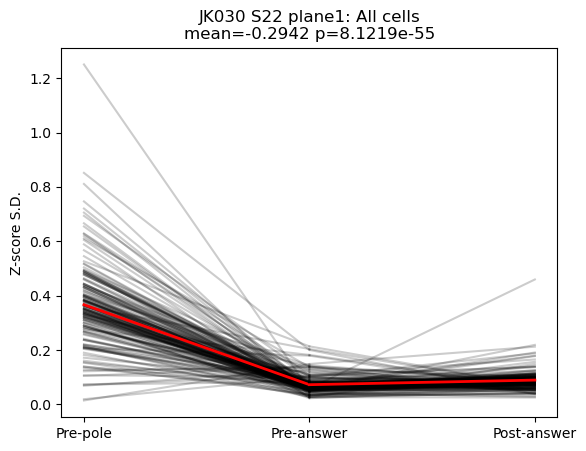

In [27]:
# Reduced variability?
p_std_change = stats.ttest_1samp(np.nanstd(pre_answer_response, axis=0) - np.nanstd(pre_pole_activity, axis=0), 0).pvalue
mean_std_change = np.mean(np.nanstd(pre_answer_response, axis=0) - np.nanstd(pre_pole_activity, axis=0))
fig, ax = plt.subplots()
pre_answer_std = np.nanstd(pre_answer_response, axis=0)
pre_pole_std = np.nanstd(pre_pole_activity, axis=0)
post_answer_std = np.nanstd(post_answer_response, axis=0)
for ii in range(pre_answer_response.shape[1]):
    ax.plot([1,2], [pre_pole_std[ii], pre_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([1,2], [np.mean(pre_pole_std), np.mean(pre_answer_std)], 'r-', linewidth=2)
for ii in range(pre_answer_response.shape[1]):
    ax.plot([2,3], [pre_answer_std[ii], post_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([2,3], [np.mean(pre_answer_std), np.mean(post_answer_std)], 'r-', linewidth=2)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
ax.set_ylabel('Z-score S.D.')
ax.set_title(f'{session_plane_info}: All cells\nmean={mean_std_change:.4f} p={p_std_change:.4e}')
plt.show()

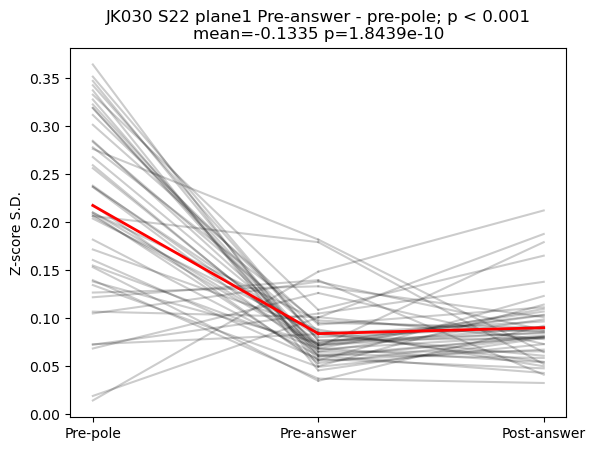

In [22]:
# What about p<0.001 cells?
p_std_change = stats.ttest_1samp(np.nanstd(pre_answer_response[:,p001_pre_answer_ind], axis=0) - np.nanstd(pre_pole_activity[:,p001_pre_answer_ind], axis=0), 0).pvalue
mean_std_change = np.mean(np.nanstd(pre_answer_response[:,p001_pre_answer_ind], axis=0) - np.nanstd(pre_pole_activity[:,p001_pre_answer_ind], axis=0))

fig, ax = plt.subplots()
pre_answer_std = np.nanstd(pre_answer_response[:,p001_pre_answer_ind], axis=0)
pre_pole_std = np.nanstd(pre_pole_activity[:,p001_pre_answer_ind], axis=0)
post_answer_std = np.nanstd(post_answer_response[:,p001_pre_answer_ind], axis=0)
for ii in range(len(p001_pre_answer_ind)):
    ax.plot([1,2], [pre_pole_std[ii], pre_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([1,2], [np.mean(pre_pole_std), np.mean(pre_answer_std)], 'r-', linewidth=2)
for ii in range(len(p001_pre_answer_ind)):
    ax.plot([2,3], [pre_answer_std[ii], post_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([2,3], [np.mean(pre_answer_std), np.mean(post_answer_std)], 'r-', linewidth=2)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
ax.set_ylabel('Z-score S.D.')
ax.set_title(f'{session_plane_info} Pre-answer - pre-pole; p < 0.001\nmean={mean_std_change:.4f} p={p_std_change:.4e}')
plt.show()

17
0


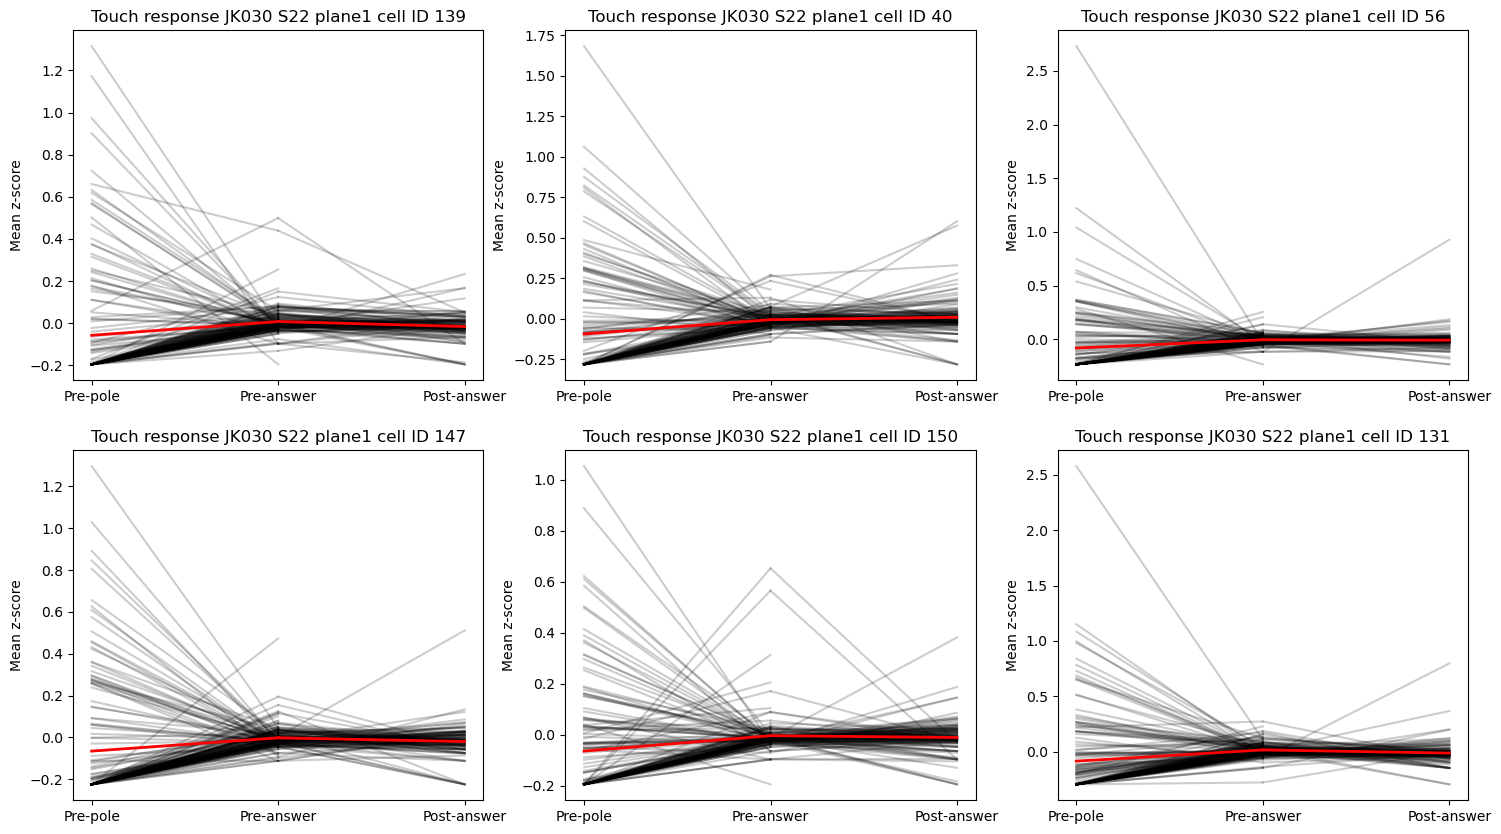

In [25]:
# 0.001 <= p < 0.01
p01_pre_answer_ind = np.setdiff1d(np.where(pvalue_pre_answer_response<0.01)[0], np.where(pvalue_pre_answer_response<0.001)[0])
print(len(p01_pre_answer_ind))
negative_response_ind = np.where(np.nanmean(pre_answer_response, axis=0) - np.nanmean(pre_pole_activity, axis=0) < 0)[0]
print(len(np.intersect1d(negative_response_ind, p01_pre_answer_ind)))
rand_inds = np.random.choice(p01_pre_answer_ind,6)
fig, ax = plt.subplots(2,3,figsize=(18,10))
for i, ind in enumerate(rand_inds):
    iy = i // 3
    ix = i % 3
    for ii in range(pre_pole_activity.shape[0]):
        ax[iy,ix].plot([1,2], [pre_pole_activity[ii,ind], pre_answer_response[ii,ind]], 'k-', alpha=0.2)
        ax[iy,ix].plot([2,3], [pre_answer_response[ii,ind], post_answer_response[ii,ind]], 'k-', alpha=0.2)
    ax[iy,ix].plot([1,2], [np.nanmean(pre_pole_activity[:,ind]), np.nanmean(pre_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].plot([2,3], [np.nanmean(pre_answer_response[:,ind]), np.nanmean(post_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].set_xticks([1,2,3])
    ax[iy,ix].set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
    ax[iy,ix].set_ylabel('Mean z-score')
    ax[iy,ix].set_title(f'Touch response {session_plane_info} cell ID {ind}')
plt.show()

16
1


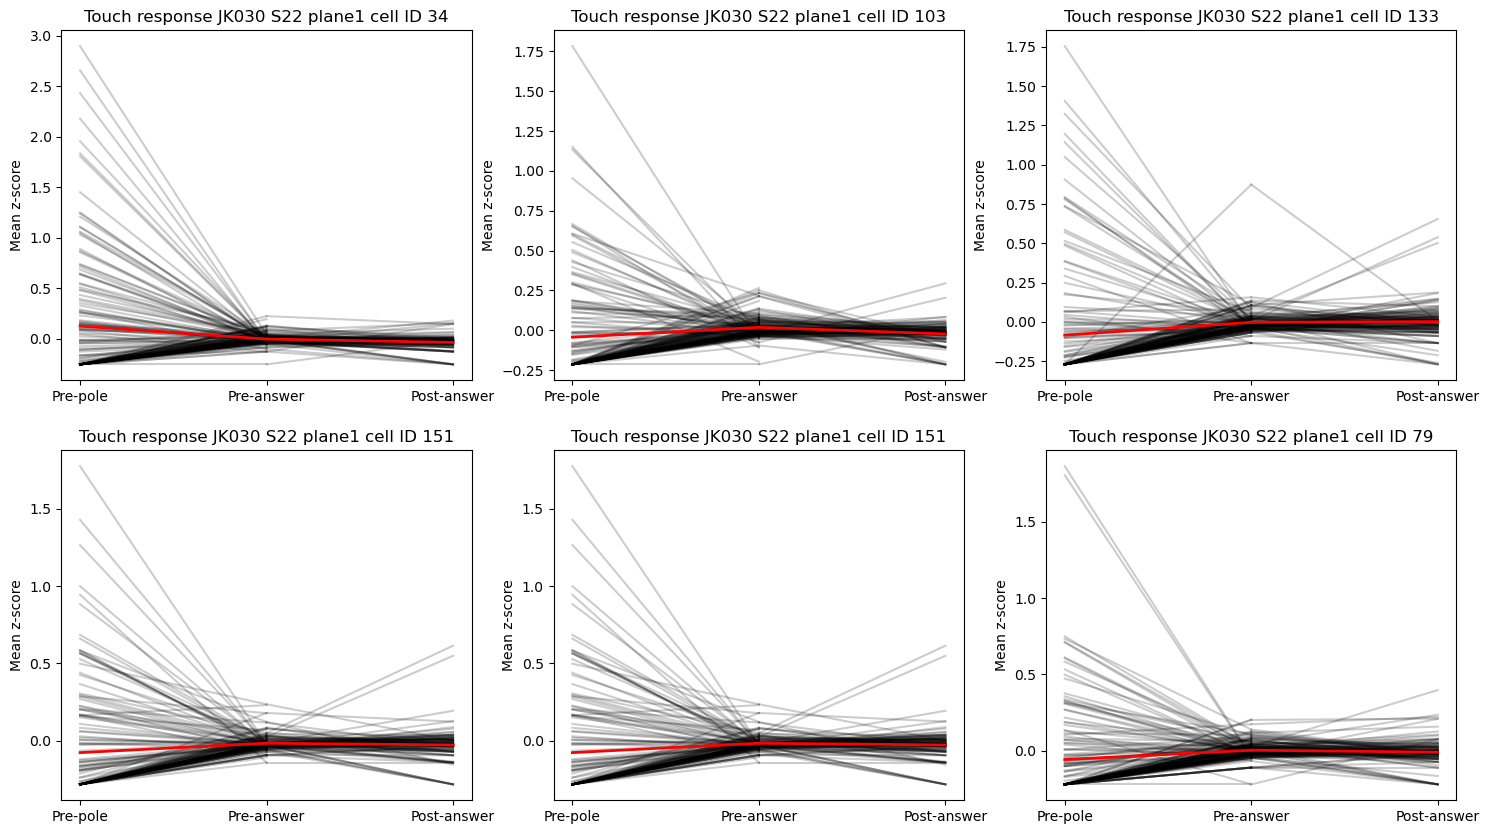

In [26]:
# 0.01 <= p < 0.05
p05_pre_answer_ind = np.setdiff1d(np.where(pvalue_pre_answer_response<0.05)[0], np.where(pvalue_pre_answer_response<0.01)[0])
print(len(p05_pre_answer_ind))
negative_response_ind = np.where(np.nanmean(pre_answer_response, axis=0) - np.nanmean(pre_pole_activity, axis=0) < 0)[0]
print(len(np.intersect1d(negative_response_ind, p05_pre_answer_ind)))
rand_inds = np.random.choice(p05_pre_answer_ind,6)
fig, ax = plt.subplots(2,3,figsize=(18,10))
for i, ind in enumerate(rand_inds):
    iy = i // 3
    ix = i % 3
    for ii in range(pre_pole_activity.shape[0]):
        ax[iy,ix].plot([1,2], [pre_pole_activity[ii,ind], pre_answer_response[ii,ind]], 'k-', alpha=0.2)
        ax[iy,ix].plot([2,3], [pre_answer_response[ii,ind], post_answer_response[ii,ind]], 'k-', alpha=0.2)
    ax[iy,ix].plot([1,2], [np.nanmean(pre_pole_activity[:,ind]), np.nanmean(pre_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].plot([2,3], [np.nanmean(pre_answer_response[:,ind]), np.nanmean(post_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].set_xticks([1,2,3])
    ax[iy,ix].set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
    ax[iy,ix].set_ylabel('Mean z-score')
    ax[iy,ix].set_title(f'Touch response {session_plane_info} cell ID {ind}')
plt.show()

# Archived analyses

In [28]:
def touch_response_prop_plot(tr_crude, target_logp_value=2, target_response=None):
    cmap = mpl.cm.get_cmap('turbo')
    task_performance = tr_crude.correct_rate.values
    num_roi = tr_crude.num_roi.values[0]
    session_nums = tr_crude.session.values
    num_sessions = len(session_nums)
    p_pre_answer = []
    for ppa in tr_crude.p_pre_answer.values:
        if len(p_pre_answer) == 0:
            p_pre_answer = -np.log10(ppa)
        else:
            p_pre_answer = np.vstack((p_pre_answer, -np.log10(ppa)))
    p_bins = [*np.round(np.arange(0,10.1,0.1),2), 10**3]
    p_pre_answer_cumdist = []
    for i in range(num_sessions):
        cumdist = np.cumsum(np.histogram(p_pre_answer[i,:], bins=p_bins)[0]/num_roi)
        if len(p_pre_answer_cumdist) == 0:
            p_pre_answer_cumdist = cumdist.copy()
        else:
            p_pre_answer_cumdist = np.vstack((p_pre_answer_cumdist, cumdist))

    effect_pre_answer = []
    for epa in tr_crude.effect_size_pre_answer.values:
        if len(effect_pre_answer) == 0:
            effect_pre_answer = epa.copy()
        else:
            effect_pre_answer = np.vstack((effect_pre_answer, epa))
    min_effect = np.percentile(effect_pre_answer[:],0.5)
    max_effect = np.amax(effect_pre_answer)
    e_bins = [*np.round(np.arange(min_effect,max_effect+0.01,0.01),2)]
    e_pre_answer_cumdist = []
    for i in range(num_sessions):
        cumdist = np.cumsum(np.histogram(effect_pre_answer[i,:], bins=e_bins)[0]/num_roi)
        if len(e_pre_answer_cumdist) == 0:
            e_pre_answer_cumdist = cumdist.copy()
        else:
            e_pre_answer_cumdist = np.vstack((e_pre_answer_cumdist, cumdist))

    fig, ax = plt.subplots(2,2,figsize=(12,10))
    for i in range(num_sessions):
        color_val = 1-i/(num_sessions-1)
        # ax[0].plot(p_bins[:-1], p_pre_answer_cumdist[i], color= np.array([1,1,1]) - np.array([*cmap(color_val)])[:-1], label=f'{session_nums[i]}')
        ax[0,0].plot(p_bins[:-1], p_pre_answer_cumdist[i], color= cmap(color_val), label=f'{session_nums[i]}')
    ax[0,0].legend()
    ax[0,0].set_xlabel('-Log(p-value)')
    ax[0,0].set_ylabel('Cumulative distribution')
    ax[0,0].set_title('p-value')
    ax[0,0].axvline(2, color=[0.5, 0.5, 0.5], linestyle='--')

    for i in range(num_sessions):
        color_val = 1-i/(num_sessions-1)
        ax[0,1].plot(e_bins[:-1], e_pre_answer_cumdist[i], color= cmap(color_val), label=f'{session_nums[i]}')
    
    ax[0,1].legend()
    ax[0,1].set_xlabel('Response amplitude (z-score)')
    ax[0,1].set_ylabel('Cumulative distribution')
    ax[0,1].set_title('Response amplitude')

    fig.suptitle(f'JK{mouse:03d} plane{plane}')

    ax[1,0].scatter(1-p_pre_answer_cumdist[:,np.argmin(np.abs(np.array(p_bins)-target_logp_value))], task_performance, c = 1-np.array(range(num_sessions))/(num_sessions-1), cmap=cmap)
    ax[1,0].set_ylabel('Performance')
    ax[1,0].set_xlabel(f'Prop neurons response p < {10**(-target_logp_value):.4f}')

    if target_response is None:
        e_ind = np.argmin(np.abs(np.mean(e_pre_answer_cumdist,axis=0)-0.8))
        target_response = e_bins[e_ind]
    else:
        e_ind = np.argmin(np.abs(np.array(e_bins)-target_response))
    ax[1,1].scatter(1-e_pre_answer_cumdist[:,e_ind], task_performance, c = 1-np.array(range(num_sessions))/(num_sessions-1), cmap=cmap)
    ax[1,1].set_ylabel('Performance')
    ax[1,1].set_xlabel(f'Prop neurons response amplitude > {target_response}')

    ax[0,1].axvline(target_response, color=[0.5,0.5,0.5], linestyle='--')


    fig.tight_layout()
    return fig

In [31]:

mouse = 30
tr_crude_all_planes = []
for plane in range(1,9):
    load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
    tr_crude = pd.read_pickle(save_dir_base / load_fn)
    tr_crude_all_planes.append(tr_crude)
    fig = touch_response_prop_plot(tr_crude)
    save_dir = save_dir_base / 'touch_prop_with_performance' / 'per_plane'
    if os.path.isdir(save_dir) == False:
        os.makedirs(save_dir)
    fig.savefig(save_dir_base / 'touch_prop_with_performance' / 'per_plane'/ f'JK{mouse:03d}_plane{plane}_touch_response_prop.png', transparent=False, bbox_inches='tight')



<ipython-input-28-12b0f5376401>:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2,2,figsize=(12,10))
